# --

## Setup

* IMPORT

In [1]:
import keras
import numpy as np
from numpy import ma
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import  classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
import random

* Set random state

In [ ]:
random_state = 42

* CHECK FOR GPU

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data

* LOAD DATA

In [3]:
# Load all data and labels
ccFieldsAll = np.load("C:/Users/mkoli/Syddansk Universitet/Morten Thyrring Stouenberg - Speciale2023/Data/AllNoAlt/ccLastImageNoCloudIndex0_6234.npy", allow_pickle=True)
labels = np.load("C:/Users/mkoli/Syddansk Universitet/Morten Thyrring Stouenberg - Speciale2023/Data/AllNoAlt/reLabelsAll.npy", allow_pickle=True)

# Cloud probability band subset
cloud_probability = ccFieldsAll[:len(labels),:,:,7]

# Subset data to true labels
ccFieldsAll = ccFieldsAll[:len(labels),:,:,[2,1,0]]

* Data to 0-255 range

In [4]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return (((band-band_min)/((band_max - band_min)))*255)


ccFieldsAll[:,:,:,0] = normalize(ccFieldsAll[:,:,:,0])
ccFieldsAll[:,:,:,1] = normalize(ccFieldsAll[:,:,:,1])
ccFieldsAll[:,:,:,2] = normalize(ccFieldsAll[:,:,:,2])

In [5]:
# We Set cloud tolerance, between 0-255
cloud_tolerance = 40
    
# We loop in the fields by the length of the dataset
for i in range(len(ccFieldsAll)):
    # we subset the image we are at in the loop
    image = ccFieldsAll[i,:,:,:]    
    # We create and apply a mask based on cloud probability over a certain value
    # We use np.logical because np.where did not work for me at the moment
    mask = np.logical_and(cloud_probability[i, :, :,] >= cloud_tolerance, cloud_probability[i, :, :] <= 256)
    # We set all masked pixels to zero, to black out cloud covered parts
    # I do not know why but it didn't work when i did not make a copy. It is just one of those times. 
    masked = image.copy()
    masked[mask] = 0
    # We are replacing the current image with the one with applied cloud mask, if no clouds then nothing is removed.
    ccFieldsAll[i] = masked

* DELETE EMPTY IMAGES, resize while were at it

In [6]:
# we want to delete the all black images, this is done by only appending images with visible RGB bands not all black.

# Initiate list for images that did not get blacked out as well as a list for labels
ccFieldsNoCloud = []
LabelsNoCloud = []

# as we are looping in the images we resize them at the same time
# so we set the size of the images
size = 128

# We loop in all the images
for i in range(len(ccFieldsAll)):
    # if the image is not all black
    if not np.all(ccFieldsAll[i] == 0):
        #we append the image and label
        ccFieldsNoCloud.append(tf.image.resize(ccFieldsAll[i], [size, size]))
        LabelsNoCloud.append(labels[i])

# We set the lists as arrays
ccFieldsNoCloud = np.array(ccFieldsNoCloud)
LabelsNoCloud   = np.array(LabelsNoCloud)

#And print the shapes to control the output and see how many fields are left. 
print(ccFieldsNoCloud.shape)
print(LabelsNoCloud.shape)

(6122, 128, 128, 3)
(6122,)


* NEW DISTRIBUTION OF LABELS

In [7]:
print(f'Number of observations : {len(LabelsNoCloud)}')

print(f'appearances of 0 in labels : {np.count_nonzero(LabelsNoCloud == 0)}({round(100*np.count_nonzero(LabelsNoCloud == 0)/len(LabelsNoCloud),2)}% of total)')
print(f'appearances of 1 in labels : {np.count_nonzero(LabelsNoCloud == 1)}({round(100*np.count_nonzero(LabelsNoCloud == 1)/len(LabelsNoCloud),2)}% of total)')
print(f'appearances of 2 in labels : {np.count_nonzero(LabelsNoCloud == 2)}({round(100*np.count_nonzero(LabelsNoCloud == 2)/len(LabelsNoCloud),2)}% of total)')

Number of observations : 6122
appearances of 0 in labels : 999(16.32% of total)
appearances of 1 in labels : 1325(21.64% of total)
appearances of 2 in labels : 3798(62.04% of total)


### CNN (RGB images)

In [8]:
# Data is split 80/20 for train and test
X_train, X_test, y_train, y_test = train_test_split(ccFieldsNoCloud, 
                                                    LabelsNoCloud, 
                                                    test_size=0.2, 
                                                    random_state=random_state)

# Train data is split 75/25, which corresponds to 20% of original 
# data as validation and 60% of original data as train
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=random_state) # 0.25 x 0.8 = 0.2

# Print the dataset shapes to inspect sizes
print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(3672, 128, 128, 3) (3672,)
(1225, 128, 128, 3) (1225,)
(1225, 128, 128, 3) (1225,)


# Data augmentation

In [9]:
#Defining augmentaation method 
 
datagen = ImageDataGenerator(
    # Rotation range is set to 360 to enable images to get any rotational angle
    rotation_range      = 360,        
    # Zoom range is a conservative 0.2 to not get too big parts of the image out of bounds
    zoom_range          = 0.2,           
    # Brightness range is random between specified values to enable brightness adjustment due to sun or shadow from clouds
    brightness_range    = (0.8,1.2),    
    # Horisontal flip is enabled. I do not know if it is going to make a difference, but it is not going to hurt. 
    horizontal_flip     = True)

In [10]:
# We initiate lists for data and labels used for augmentation
data_for_augmentation = []
labels_for_augmentation = []

# We Loop Loop data and append fields to each class for single class data augmentation 
for i in range(len(y_train)):
  if y_train[i] == 0:
    data_for_augmentation.append(X_train[i])
    labels_for_augmentation.append(y_train[i])
  if y_train[i] == 1:
    data_for_augmentation.append(X_train[i])
    labels_for_augmentation.append(y_train[i])

# save as numpy arrays
data_for_augmentation    = np.asarray(data_for_augmentation)
labels_for_augmentation    = np.asarray(labels_for_augmentation)

# Check  array shape
print(f'data for augmentation : {data_for_augmentation.shape} labels for augmentation : {labels_for_augmentation.shape}')

data for augmentation : (1412, 128, 128, 3) labels for augmentation : (1412,)


In [11]:
# We set a specified number of images for augmentation per image in the dataset
num_samples_per_image = 7
# num_samples_per_image = 9
# num_samples_per_image = 11

# We reshaping data, i am not sure why, but stack overflow helped me get here.
aug_dataset            = data_for_augmentation.reshape(data_for_augmentation.shape[0], 
                                                      data_for_augmentation.shape[1], 
                                                      data_for_augmentation.shape[2], 
                                                      3)

# We initiate a list of labels for augmented data
labels_aug = []
# We create an empty list for the augmented images
augmented_images = []

# We loop in the length of the dataset
for i in range(len(aug_dataset)):
    # We loop in the desired amount of images augmented for each image
    for j in range(num_samples_per_image):
        # we subset the image
        img = data_for_augmentation[i]
        # we expand dimensions as described on the tensorflow website 
        # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator 
        img = np.expand_dims(img, axis=0)
        # We use the datagen.flow to flow one image at the time into the augmenting imagedatagenerator
        # I am not entirely sure about the .next when using only one image but it works, in theory we do not need it but i do not want to remove something when it works. 
        augmented_img = datagen.flow(img, batch_size=1, shuffle=False).next()
        #as we have expanded the dimensiong we need to sqeeze it all back together for a functioning image again
        augmented_img = augmented_img.squeeze(axis=0)
        # We append the image and labels to our lists
        augmented_images.append(augmented_img)
        labels_aug.append(labels_for_augmentation[i])

#Turn it all into numpy arrays
labels_aug=np.asarray(labels_aug)
augmented_images=np.asarray(augmented_images)

In [12]:
# We concatenate the data to make sure the training dataset is now the original train data and the augmented data
X_train = np.concatenate((X_train, augmented_images), axis=0)
y_train = np.concatenate((y_train, labels_aug), axis=0)

In [ ]:
# We shuffle the data to ensure there is not only accepted fields in the start of the dataset
# we set a list of indexes that is randomly shuffled
idx = np.random.permutation(len(X_train))
# We use these indexes to set the images with corresponding labels
X_trainx,y_train = X_train[idx], y_train[idx]

In [13]:
print(f'Number of observations : {len(y_train)}')

print(f'appearances of 0 in labels : {np.count_nonzero(y_train == 0)}({round(100*np.count_nonzero(y_train == 0)/len(y_train),2)}% of total)')
print(f'appearances of 1 in labels : {np.count_nonzero(y_train == 1)}({round(100*np.count_nonzero(y_train == 1)/len(y_train),2)}% of total)')
print(f'appearances of 2 in labels : {np.count_nonzero(y_train == 2)}({round(100*np.count_nonzero(y_train == 2)/len(y_train),2)}% of total)')

Number of observations : 13556
appearances of 0 in labels : 4832(35.64% of total)
appearances of 1 in labels : 6464(47.68% of total)
appearances of 2 in labels : 2260(16.67% of total)


# Deep Learning Models

In [14]:
X_train = tf.keras.applications.inception_v3.preprocess_input(X_train, data_format=None)
X_test = tf.keras.applications.inception_v3.preprocess_input(X_test, data_format=None)
X_val = tf.keras.applications.inception_v3.preprocess_input(X_val, data_format=None)

# Inception V3 - Hyperparametersearch

In [ ]:
def His_metrics(history, cp_filepath):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(f'Training and Validation Loss {cp_filepath}')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(f'Training and Validation Loss {cp_filepath}')
    plt.xlabel('epoch')
    plt.show()

def Viz_metrics(X_test, y_test, model, cp_filepath):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(classification_report(y_test, y_pred_classes))
    cm = confusion_matrix(y_test, y_pred_classes)
    class_names = ['Failed (0)', 'Partially (1)', 'Accepted (2)']
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap=plt.cm.OrRd)
    plt.title(f'Confusion Matrix \n {cp_filepath}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.colorbar()
    for k in range(len(class_names)):
        for h in range(len(class_names)):
            plt.text(h, k, cm[k, h], ha='center', va='center', color='black')

    plt.show()        


In [15]:
histories = []
name = []

ft_histories = []
ft_name = []

### For 0.0001 learning rate 

Running 6 possible models with learning rates:[0.0001] and batch sizes: [64, 32, 16] with dropouts: [0.2, 0.5] for epochs: 100
Running: 
 learning rate:0.0001, batch size: 64 with dropout: 0.2 for epochs: 100
Epoch 1/100
212/212 [==============================] - 19s 52ms/step - loss: 1.1104 - accuracy: 0.4833 - val_loss: 1.8398 - val_accuracy: 0.2645
Epoch 2/100
212/212 [==============================] - 10s 46ms/step - loss: 1.0208 - accuracy: 0.5224 - val_loss: 1.1310 - val_accuracy: 0.5322
Epoch 3/100
212/212 [==============================] - 9s 43ms/step - loss: 0.9473 - accuracy: 0.5516 - val_loss: 1.2985 - val_accuracy: 0.4588
Epoch 4/100
212/212 [==============================] - 9s 43ms/step - loss: 0.9143 - accuracy: 0.5676 - val_loss: 1.6774 - val_accuracy: 0.3282
Epoch 5/100
212/212 [==============================] - 9s 43ms/step - loss: 0.8878 - accuracy: 0.5771 - val_loss: 1.3607 - val_accuracy: 0.4318
Epoch 6/100
212/212 [==============================] - 9s 43ms/step -

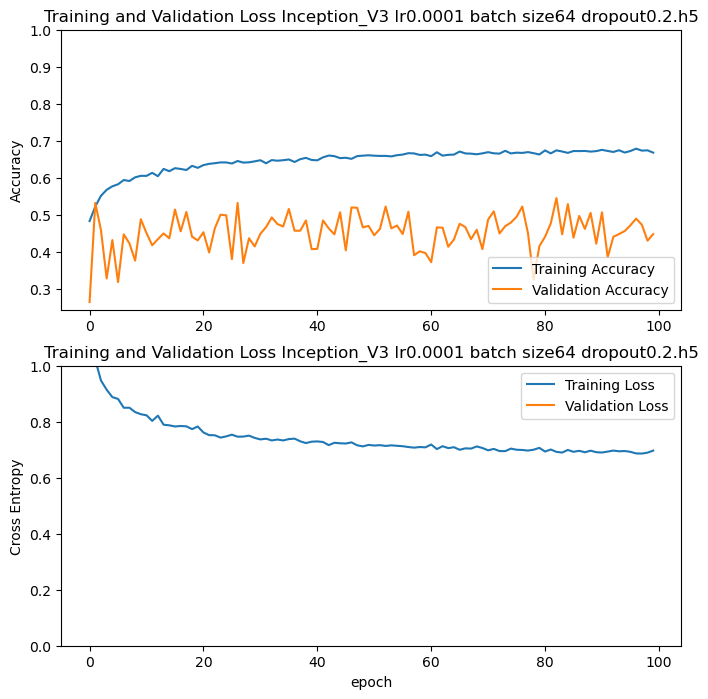

39/39 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0       0.26      0.21      0.23       208
           1       0.28      0.39      0.33       250
           2       0.70      0.65      0.68       767

    accuracy                           0.52      1225
   macro avg       0.42      0.42      0.41      1225
weighted avg       0.54      0.52      0.53      1225



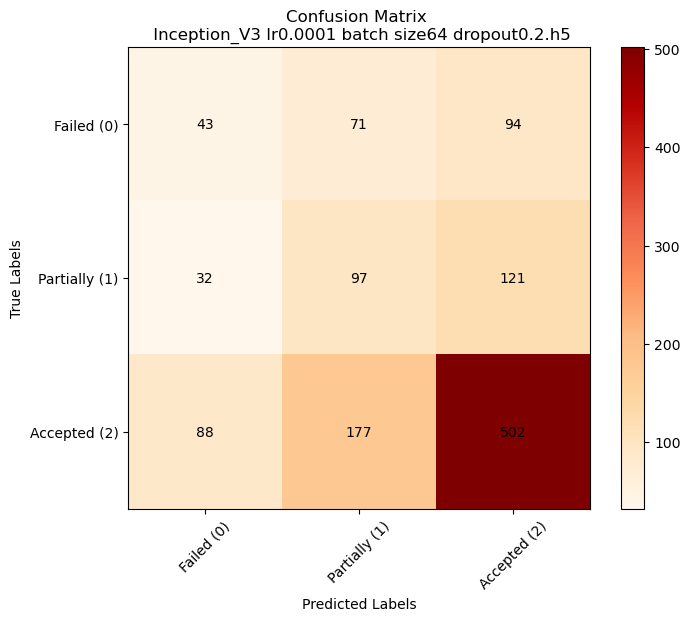

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_______________________________________

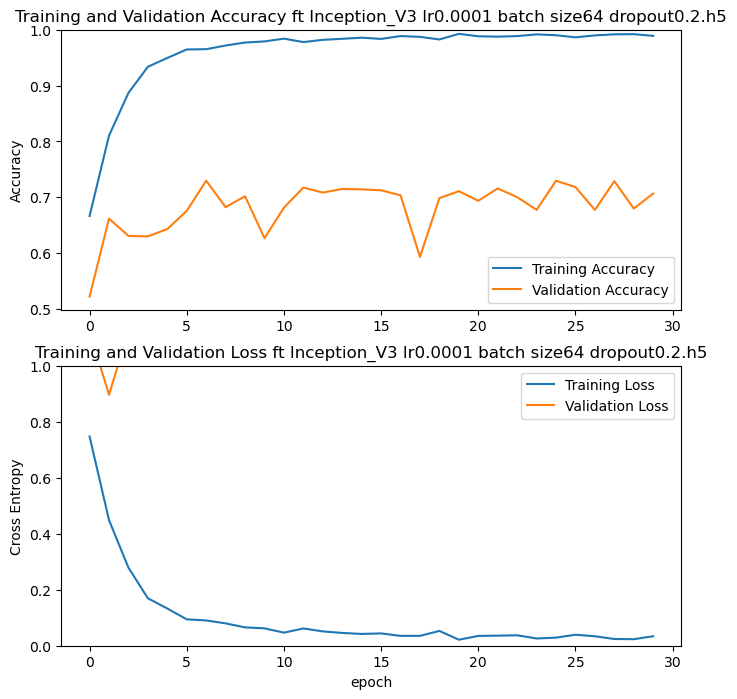

39/39 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

           0       0.78      0.53      0.63       208
           1       0.47      0.38      0.42       250
           2       0.78      0.90      0.84       767

    accuracy                           0.73      1225
   macro avg       0.68      0.60      0.63      1225
weighted avg       0.72      0.73      0.72      1225



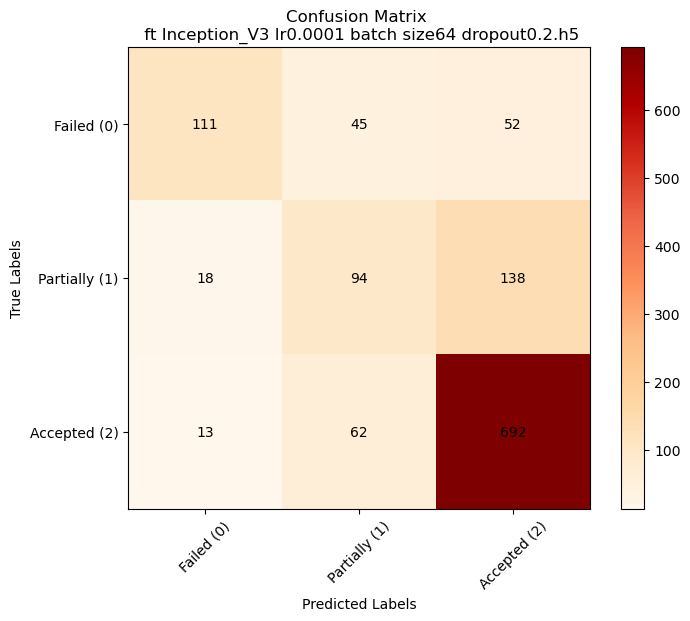

Running: 
 learning rate:0.0001, batch size: 64 with dropout: 0.5 for epochs: 100
Epoch 1/100
212/212 [==============================] - 14s 50ms/step - loss: 1.3040 - accuracy: 0.4684 - val_loss: 1.3081 - val_accuracy: 0.4261
Epoch 2/100
212/212 [==============================] - 10s 45ms/step - loss: 1.1308 - accuracy: 0.5100 - val_loss: 1.1767 - val_accuracy: 0.5135
Epoch 3/100
212/212 [==============================] - 9s 44ms/step - loss: 1.0734 - accuracy: 0.5305 - val_loss: 1.2159 - val_accuracy: 0.4963
Epoch 4/100
212/212 [==============================] - 10s 45ms/step - loss: 1.0079 - accuracy: 0.5509 - val_loss: 1.1740 - val_accuracy: 0.5298
Epoch 5/100
212/212 [==============================] - 9s 44ms/step - loss: 0.9817 - accuracy: 0.5578 - val_loss: 1.3014 - val_accuracy: 0.4653
Epoch 6/100
212/212 [==============================] - 9s 44ms/step - loss: 0.9577 - accuracy: 0.5649 - val_loss: 1.5610 - val_accuracy: 0.3861
Epoch 7/100
212/212 [==============================

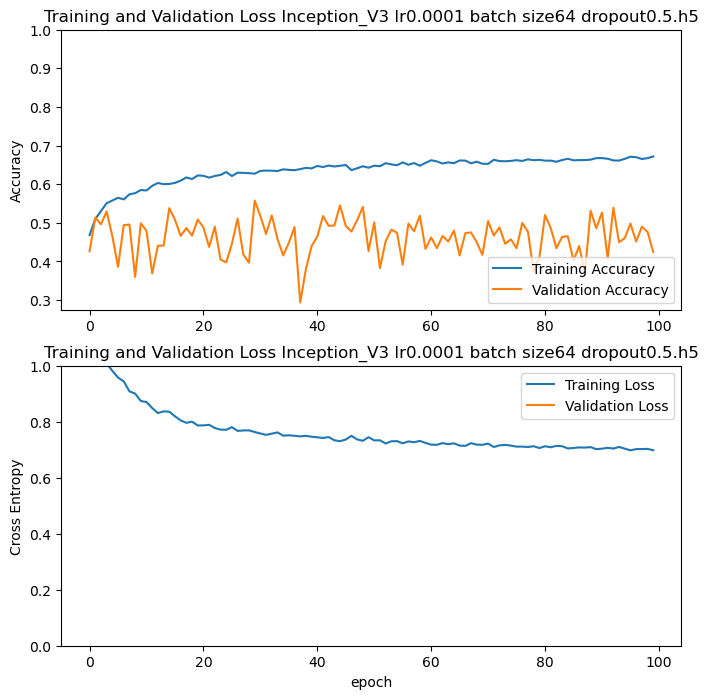

39/39 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       0.28      0.15      0.19       208
           1       0.29      0.35      0.32       250
           2       0.69      0.73      0.71       767

    accuracy                           0.55      1225
   macro avg       0.42      0.41      0.41      1225
weighted avg       0.54      0.55      0.54      1225



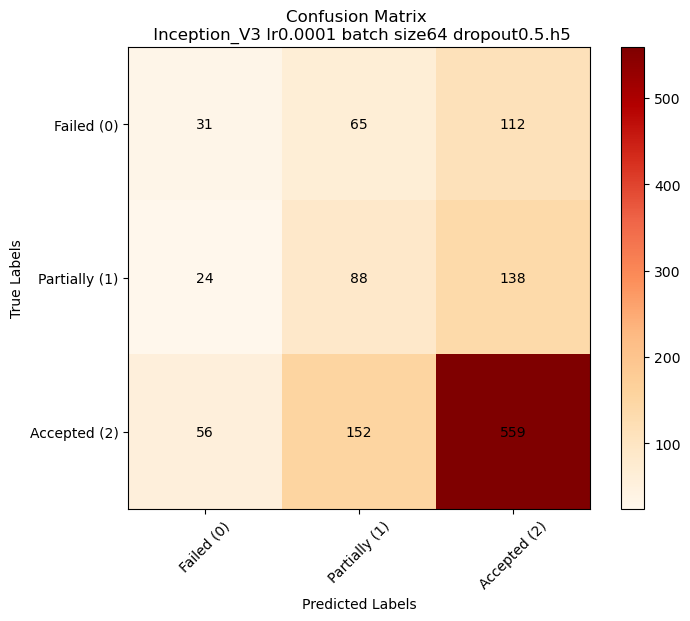

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

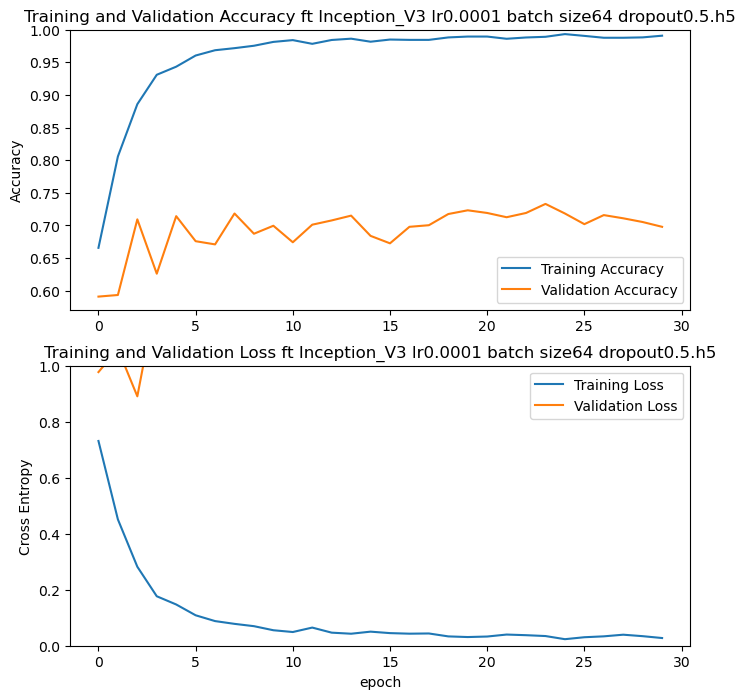

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.71      0.58      0.64       208
           1       0.51      0.40      0.45       250
           2       0.81      0.90      0.85       767

    accuracy                           0.75      1225
   macro avg       0.68      0.63      0.65      1225
weighted avg       0.73      0.75      0.73      1225



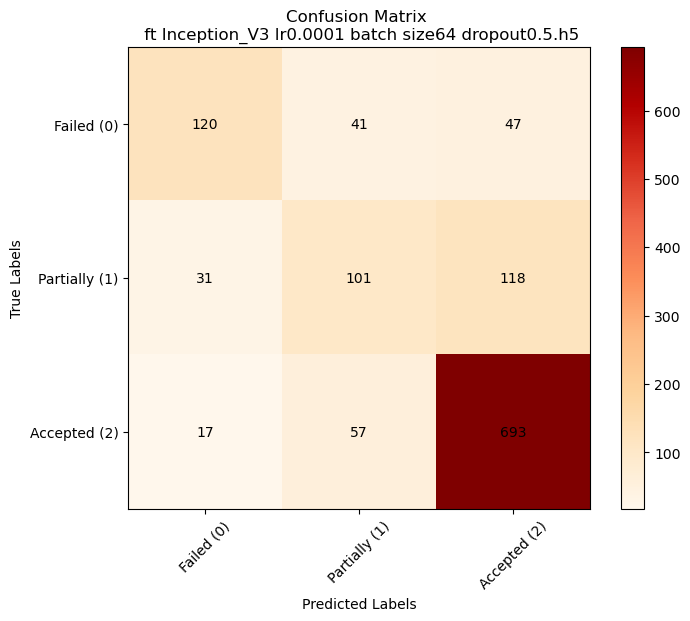

Running: 
 learning rate:0.0001, batch size: 32 with dropout: 0.2 for epochs: 100
Epoch 1/100
424/424 [==============================] - 16s 31ms/step - loss: 1.1824 - accuracy: 0.4838 - val_loss: 1.5200 - val_accuracy: 0.3731
Epoch 2/100
424/424 [==============================] - 12s 28ms/step - loss: 1.0897 - accuracy: 0.5207 - val_loss: 1.8293 - val_accuracy: 0.3127
Epoch 3/100
424/424 [==============================] - 12s 29ms/step - loss: 0.9777 - accuracy: 0.5440 - val_loss: 1.5233 - val_accuracy: 0.3976
Epoch 4/100
424/424 [==============================] - 12s 29ms/step - loss: 0.9378 - accuracy: 0.5658 - val_loss: 1.2268 - val_accuracy: 0.4955
Epoch 5/100
424/424 [==============================] - 12s 28ms/step - loss: 0.9297 - accuracy: 0.5709 - val_loss: 1.3362 - val_accuracy: 0.4506
Epoch 6/100
424/424 [==============================] - 12s 28ms/step - loss: 0.8826 - accuracy: 0.5834 - val_loss: 1.3139 - val_accuracy: 0.4620
Epoch 7/100
424/424 [===========================

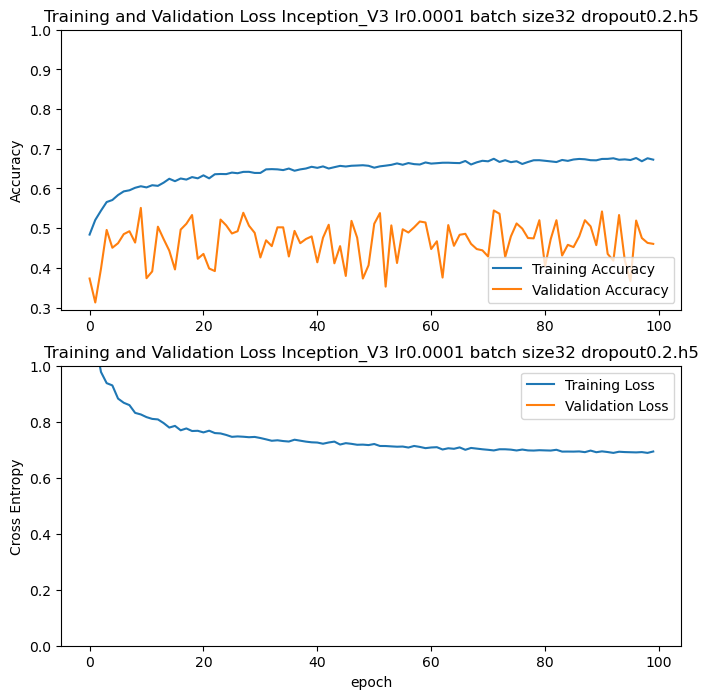

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.28      0.22      0.24       208
           1       0.29      0.30      0.29       250
           2       0.69      0.72      0.71       767

    accuracy                           0.55      1225
   macro avg       0.42      0.41      0.41      1225
weighted avg       0.54      0.55      0.54      1225



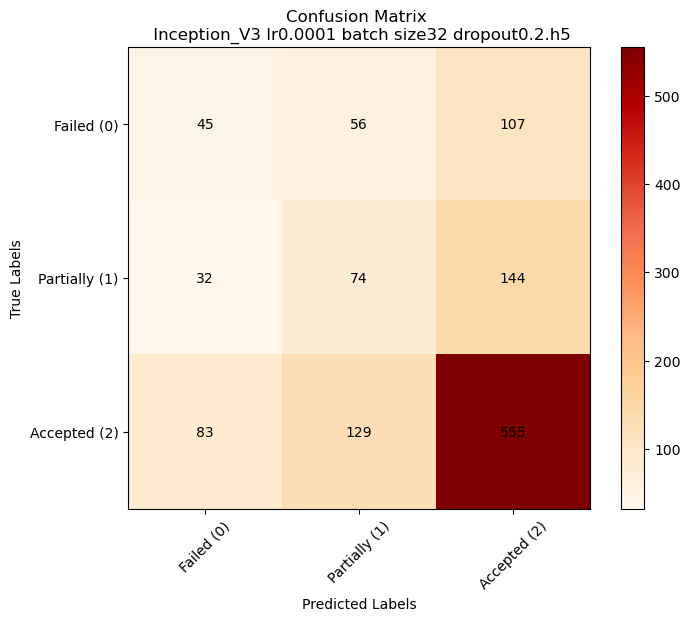

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

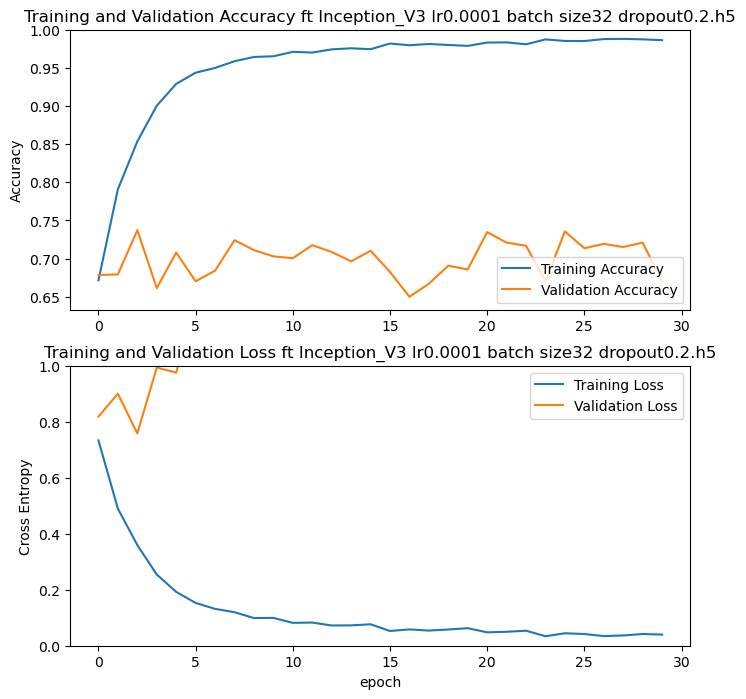

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.64      0.69      0.66       208
           1       0.58      0.33      0.42       250
           2       0.81      0.91      0.86       767

    accuracy                           0.75      1225
   macro avg       0.68      0.64      0.65      1225
weighted avg       0.74      0.75      0.74      1225



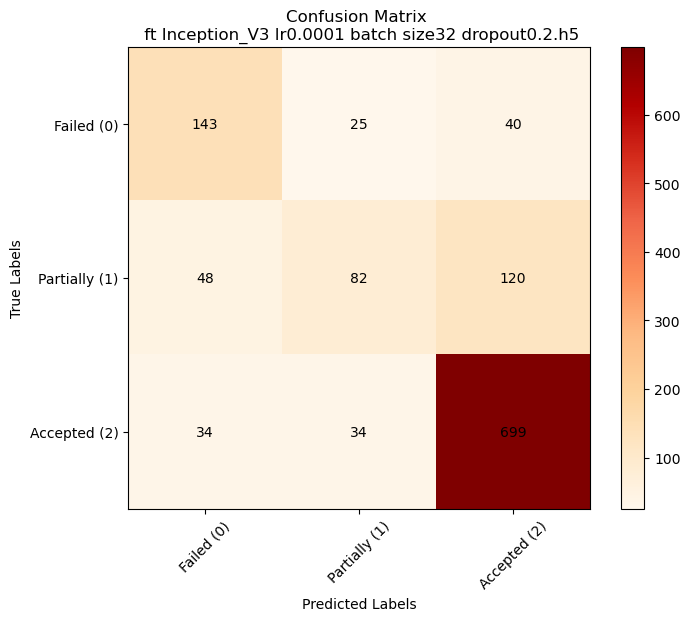

Running: 
 learning rate:0.0001, batch size: 32 with dropout: 0.5 for epochs: 100
Epoch 1/100
424/424 [==============================] - 15s 30ms/step - loss: 1.3221 - accuracy: 0.4664 - val_loss: 1.1400 - val_accuracy: 0.5404
Epoch 2/100
424/424 [==============================] - 11s 27ms/step - loss: 1.1686 - accuracy: 0.5057 - val_loss: 1.3018 - val_accuracy: 0.4612
Epoch 3/100
424/424 [==============================] - 11s 27ms/step - loss: 1.0659 - accuracy: 0.5331 - val_loss: 1.7165 - val_accuracy: 0.3567
Epoch 4/100
424/424 [==============================] - 12s 28ms/step - loss: 1.0323 - accuracy: 0.5472 - val_loss: 1.1494 - val_accuracy: 0.5624
Epoch 5/100
424/424 [==============================] - 11s 27ms/step - loss: 0.9996 - accuracy: 0.5495 - val_loss: 1.4670 - val_accuracy: 0.4122
Epoch 6/100
424/424 [==============================] - 11s 27ms/step - loss: 0.9412 - accuracy: 0.5616 - val_loss: 1.3189 - val_accuracy: 0.4980
Epoch 7/100
424/424 [===========================

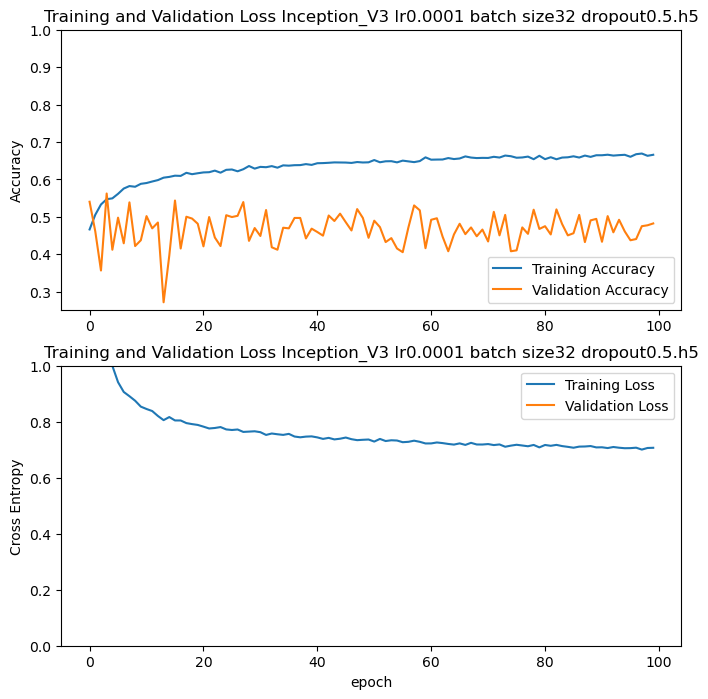

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.31      0.27      0.29       208
           1       0.31      0.25      0.28       250
           2       0.68      0.75      0.72       767

    accuracy                           0.57      1225
   macro avg       0.43      0.42      0.43      1225
weighted avg       0.54      0.57      0.55      1225



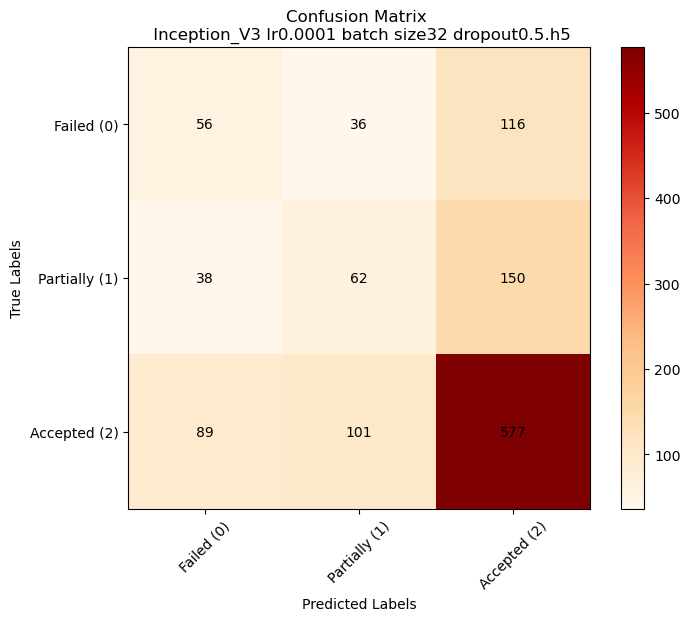

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

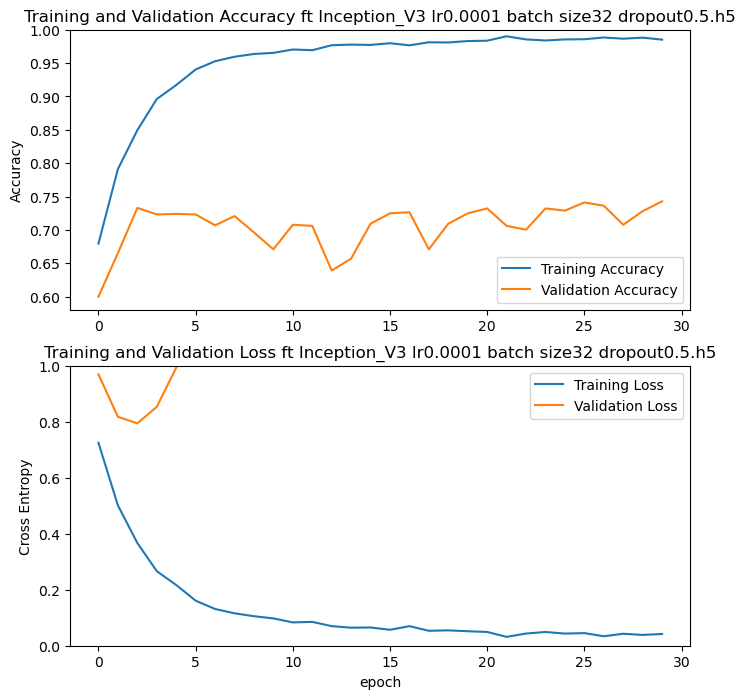

39/39 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       208
           1       0.49      0.27      0.35       250
           2       0.79      0.93      0.86       767

    accuracy                           0.75      1225
   macro avg       0.66      0.61      0.63      1225
weighted avg       0.72      0.75      0.72      1225



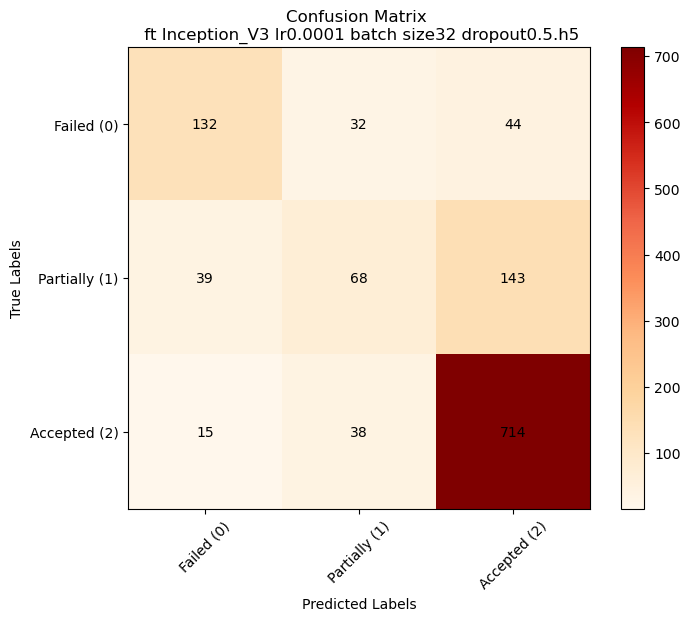

Running: 
 learning rate:0.0001, batch size: 16 with dropout: 0.2 for epochs: 100
Epoch 1/100
848/848 [==============================] - 22s 22ms/step - loss: 1.2993 - accuracy: 0.4802 - val_loss: 1.4677 - val_accuracy: 0.3967
Epoch 2/100
848/848 [==============================] - 18s 21ms/step - loss: 1.0900 - accuracy: 0.5218 - val_loss: 1.3341 - val_accuracy: 0.4645
Epoch 3/100
848/848 [==============================] - 17s 20ms/step - loss: 1.0048 - accuracy: 0.5485 - val_loss: 1.3599 - val_accuracy: 0.4498
Epoch 4/100
848/848 [==============================] - 17s 20ms/step - loss: 0.9407 - accuracy: 0.5666 - val_loss: 1.4513 - val_accuracy: 0.4114
Epoch 5/100
848/848 [==============================] - 17s 20ms/step - loss: 0.9141 - accuracy: 0.5679 - val_loss: 1.4665 - val_accuracy: 0.4073
Epoch 6/100
848/848 [==============================] - 18s 21ms/step - loss: 0.8898 - accuracy: 0.5777 - val_loss: 1.2339 - val_accuracy: 0.5086
Epoch 7/100
848/848 [===========================

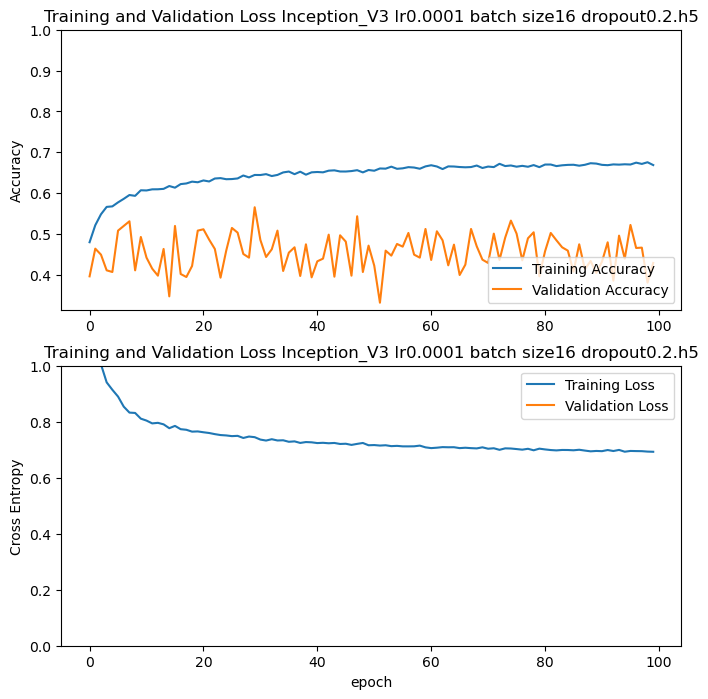

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.30      0.26      0.28       208
           1       0.32      0.25      0.28       250
           2       0.69      0.76      0.72       767

    accuracy                           0.57      1225
   macro avg       0.44      0.42      0.43      1225
weighted avg       0.55      0.57      0.56      1225



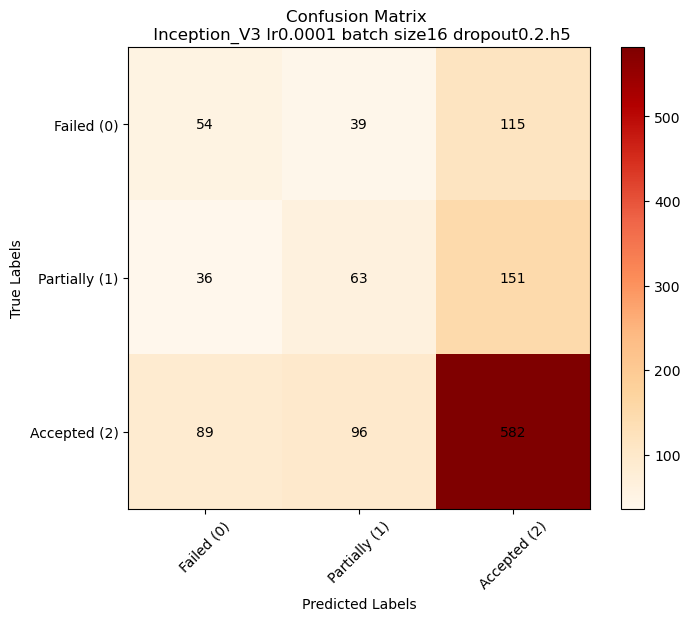

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

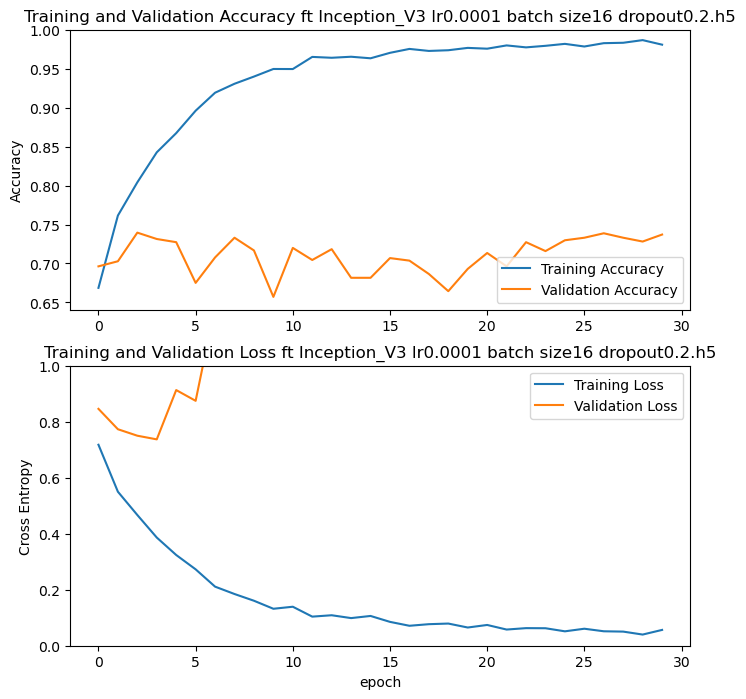

39/39 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       208
           1       0.53      0.32      0.40       250
           2       0.79      0.92      0.85       767

    accuracy                           0.75      1225
   macro avg       0.68      0.62      0.64      1225
weighted avg       0.72      0.75      0.73      1225



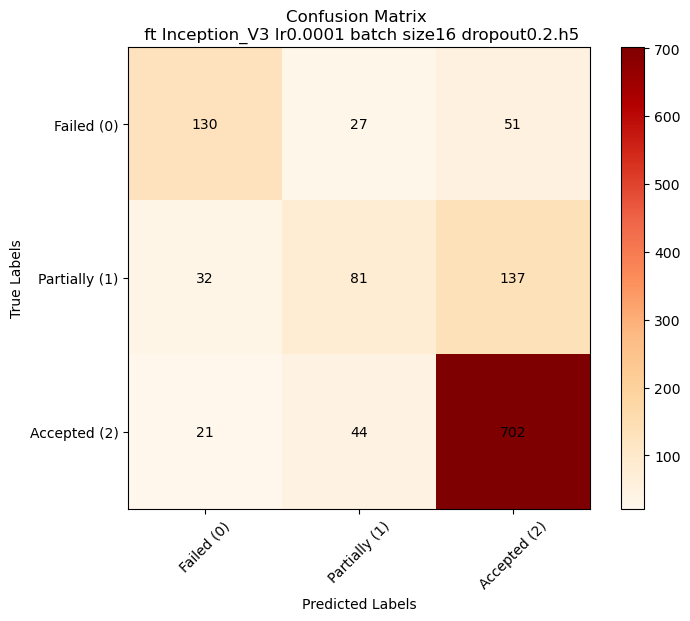

Running: 
 learning rate:0.0001, batch size: 16 with dropout: 0.5 for epochs: 100
Epoch 1/100
848/848 [==============================] - 21s 22ms/step - loss: 1.4534 - accuracy: 0.4742 - val_loss: 1.2279 - val_accuracy: 0.5363
Epoch 2/100
848/848 [==============================] - 17s 20ms/step - loss: 1.2080 - accuracy: 0.5150 - val_loss: 1.4690 - val_accuracy: 0.4376
Epoch 3/100
848/848 [==============================] - 17s 20ms/step - loss: 1.1120 - accuracy: 0.5347 - val_loss: 1.5496 - val_accuracy: 0.3731
Epoch 4/100
848/848 [==============================] - 17s 20ms/step - loss: 1.0337 - accuracy: 0.5414 - val_loss: 1.5694 - val_accuracy: 0.3894
Epoch 5/100
848/848 [==============================] - 17s 20ms/step - loss: 0.9629 - accuracy: 0.5572 - val_loss: 1.3505 - val_accuracy: 0.4792
Epoch 6/100
848/848 [==============================] - 17s 20ms/step - loss: 0.9132 - accuracy: 0.5682 - val_loss: 1.6410 - val_accuracy: 0.3535
Epoch 7/100
848/848 [===========================

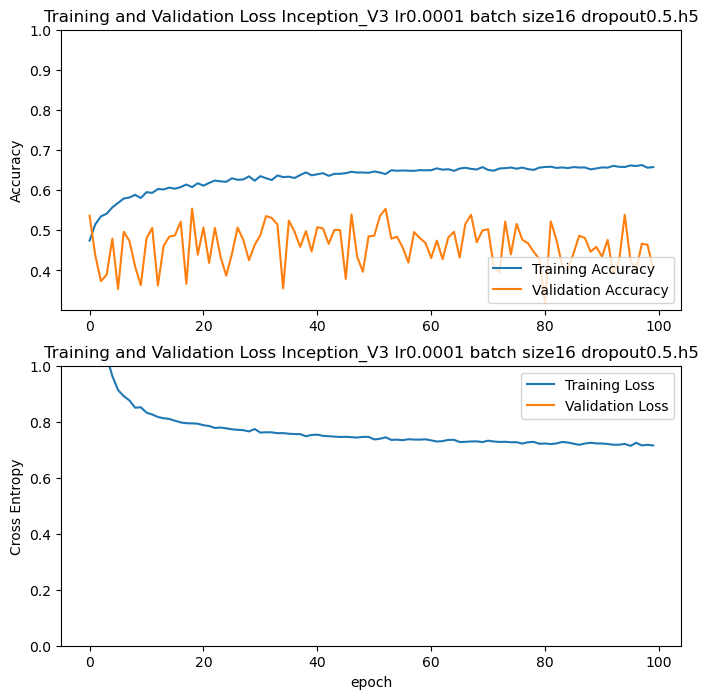

39/39 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       0.30      0.28      0.29       208
           1       0.29      0.24      0.26       250
           2       0.69      0.74      0.71       767

    accuracy                           0.56      1225
   macro avg       0.43      0.42      0.42      1225
weighted avg       0.54      0.56      0.55      1225



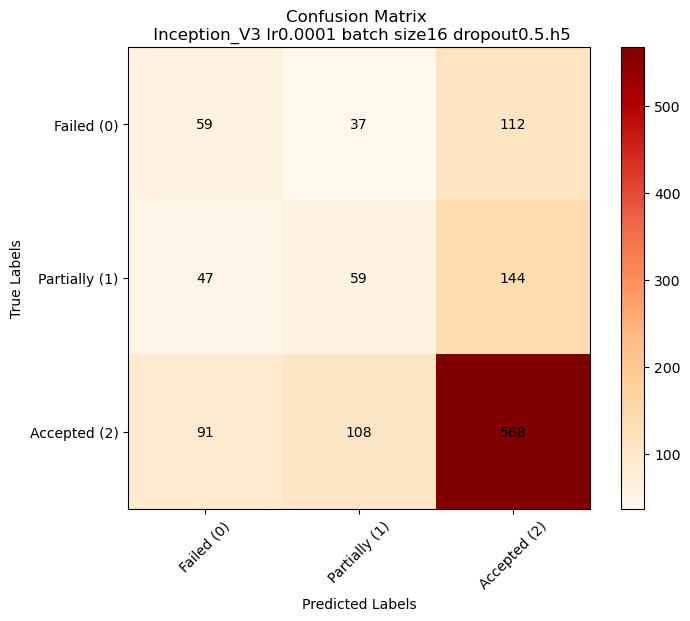

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

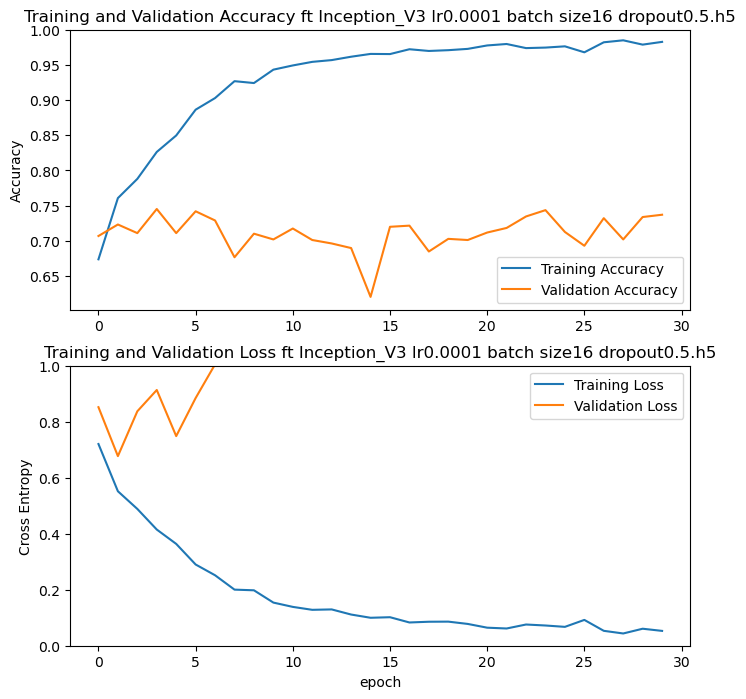

39/39 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       208
           1       0.51      0.42      0.46       250
           2       0.83      0.88      0.85       767

    accuracy                           0.75      1225
   macro avg       0.68      0.66      0.67      1225
weighted avg       0.74      0.75      0.74      1225



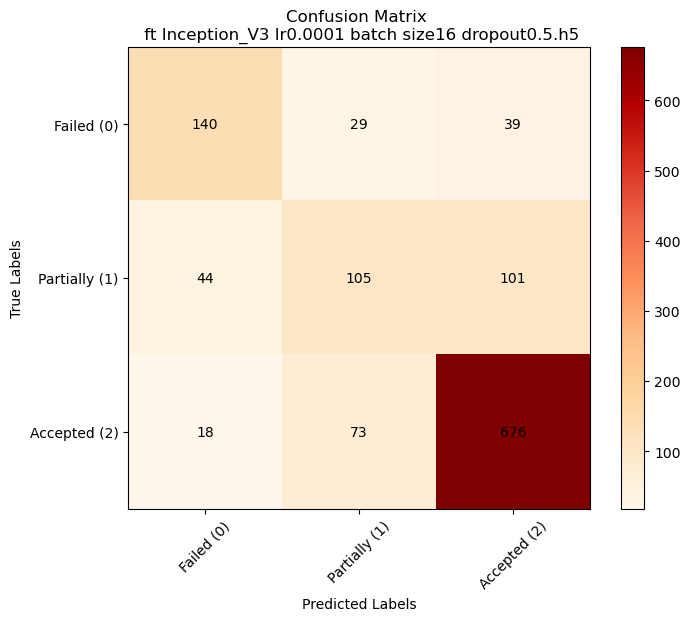

In [16]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.0001]
batch_size = [64,32,16]
dropouts = [0.2, 0.5]

####################################################################################################################
#           We define our model specific parameters

model_name = "Inception_V3" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running {len(learning_rate)*len(batch_size)*len(dropouts)} possible models with learning rates:{learning_rate} and batch sizes: {batch_size} with dropouts: {dropouts} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
        for d in dropouts:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} with dropout: {d} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.InceptionV3(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(2048, activation='linear'),  
                tf.keras.layers.Dropout(d),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  


            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  


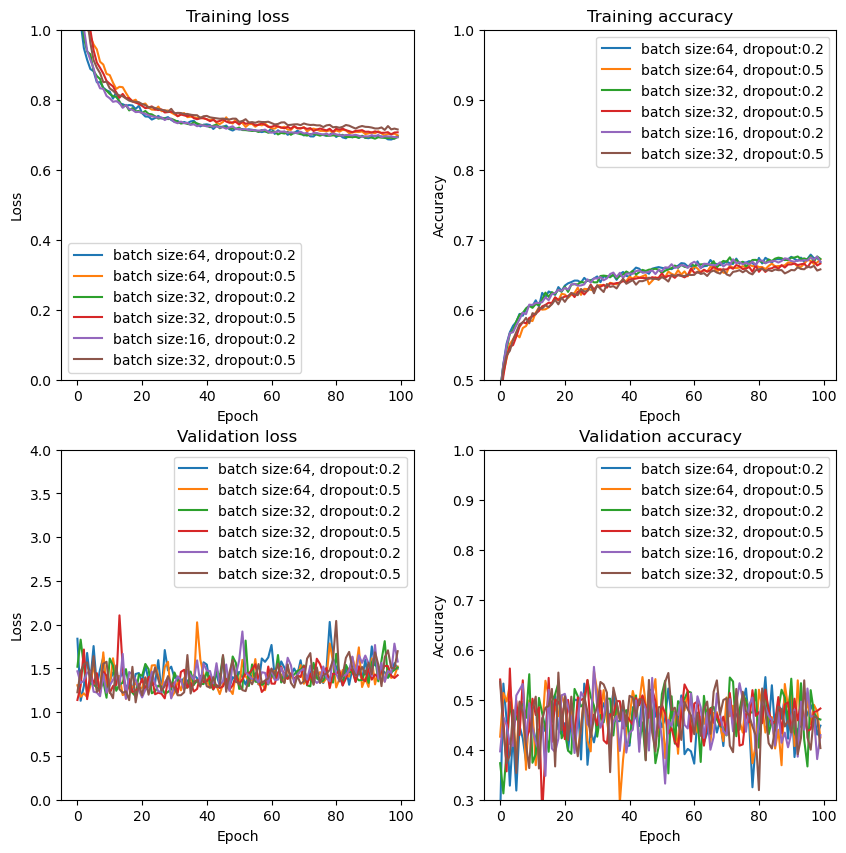

In [17]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['loss'], label='batch size:32, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['accuracy'], label='batch size:32, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_accuracy'], label='batch size:32, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('top_layer_metrics.png')
plt.show()

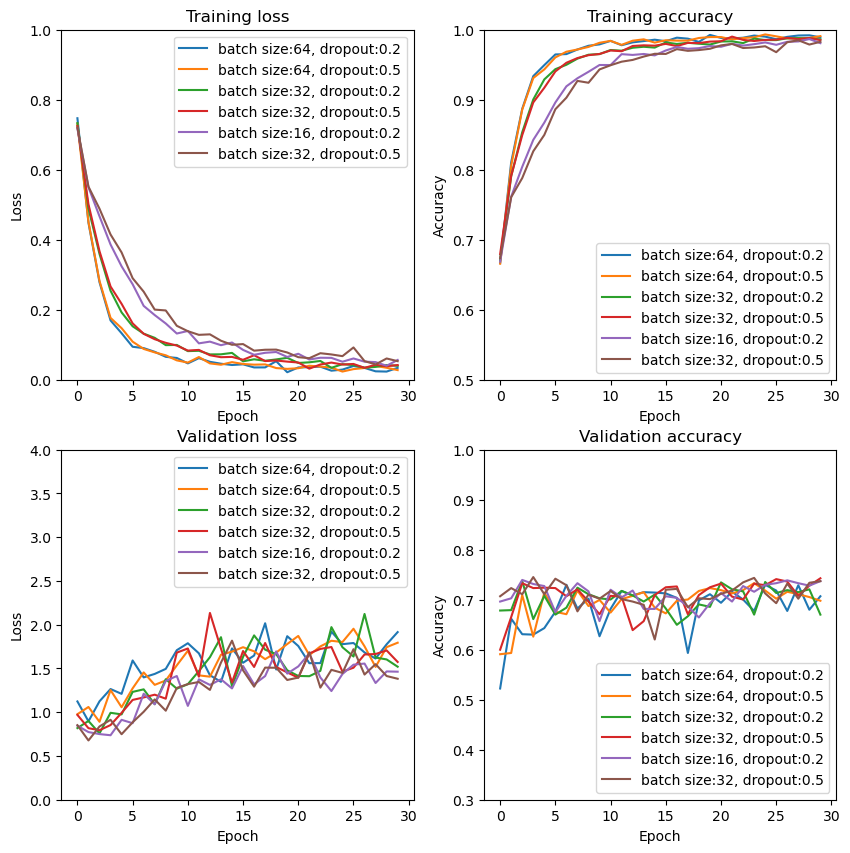

In [18]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(ft_histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['loss'], label='batch size:32, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(ft_histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['accuracy'], label='batch size:32, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(ft_histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(ft_histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_accuracy'], label='batch size:32, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()

### For 0.001 learning rate

Running 6 possible models with learning rates:[0.001] and batch sizes: [64, 32, 16] with dropouts: [0.2, 0.5] for epochs: 100
Running: 
 learning rate:0.001, batch size: 64 with dropout: 0.2 for epochs: 100
Epoch 1/100
212/212 [==============================] - 19s 52ms/step - loss: 2.0424 - accuracy: 0.4807 - val_loss: 1.2240 - val_accuracy: 0.5347
Epoch 2/100
212/212 [==============================] - 9s 43ms/step - loss: 0.9481 - accuracy: 0.5308 - val_loss: 1.1236 - val_accuracy: 0.4971
Epoch 3/100
212/212 [==============================] - 9s 43ms/step - loss: 0.8994 - accuracy: 0.5406 - val_loss: 1.1901 - val_accuracy: 0.4710
Epoch 4/100
212/212 [==============================] - 10s 46ms/step - loss: 0.8820 - accuracy: 0.5565 - val_loss: 1.0520 - val_accuracy: 0.5624
Epoch 5/100
212/212 [==============================] - 9s 44ms/step - loss: 0.8730 - accuracy: 0.5617 - val_loss: 1.2203 - val_accuracy: 0.4686
Epoch 6/100
212/212 [==============================] - 9s 44ms/step - l

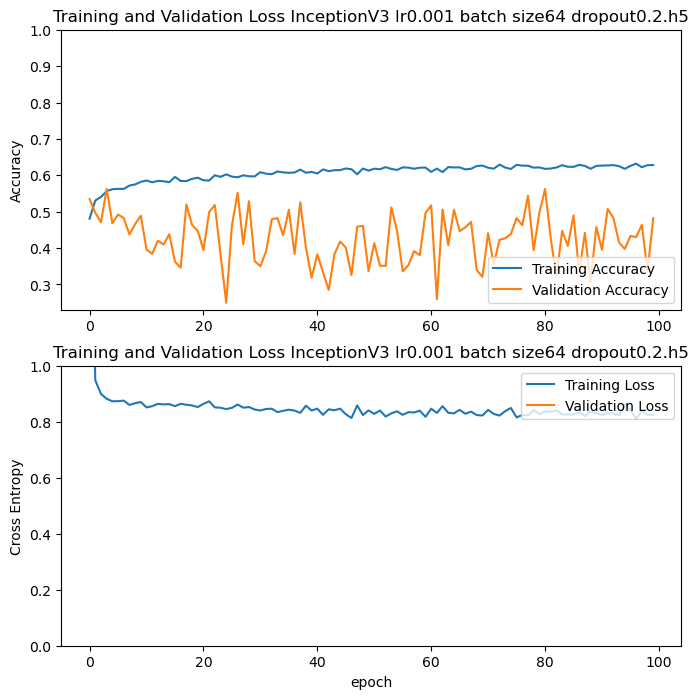

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.37      0.20      0.26       208
           1       0.30      0.25      0.27       250
           2       0.68      0.80      0.74       767

    accuracy                           0.59      1225
   macro avg       0.45      0.42      0.42      1225
weighted avg       0.55      0.59      0.56      1225



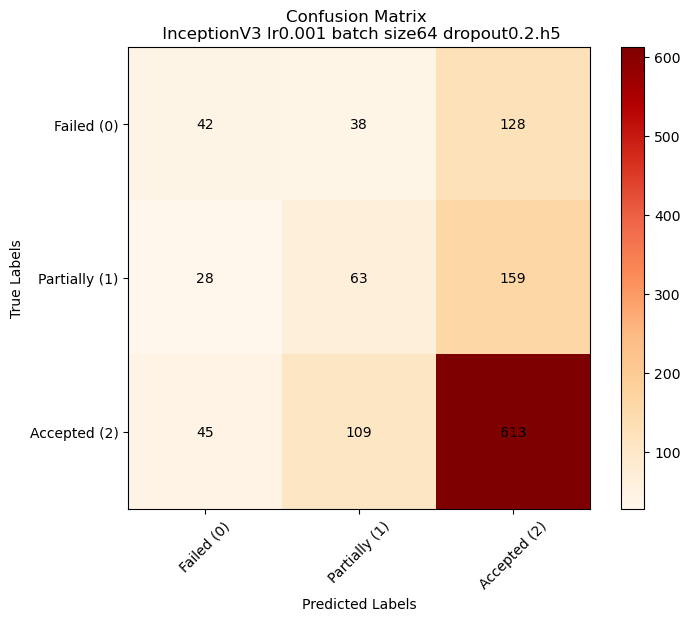

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

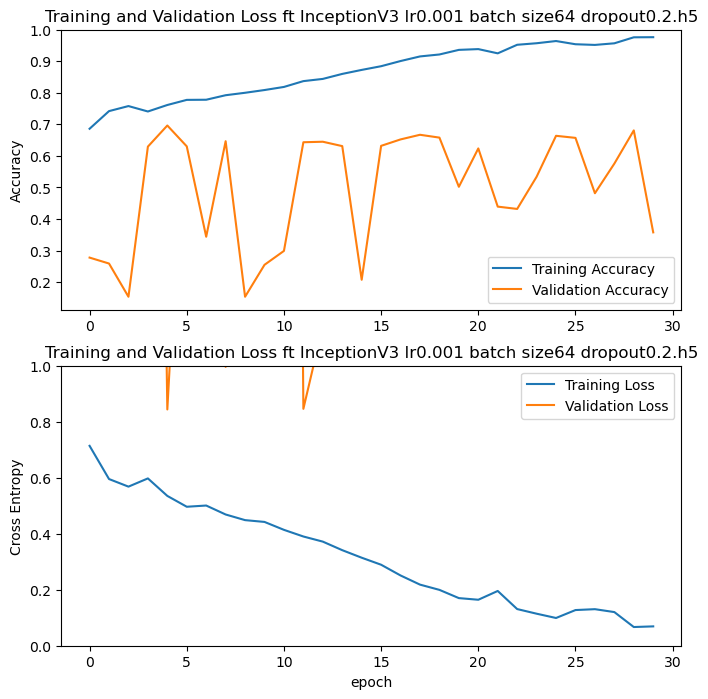

39/39 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       208
           1       0.47      0.46      0.46       250
           2       0.83      0.86      0.84       767

    accuracy                           0.72      1225
   macro avg       0.64      0.62      0.63      1225
weighted avg       0.72      0.72      0.72      1225



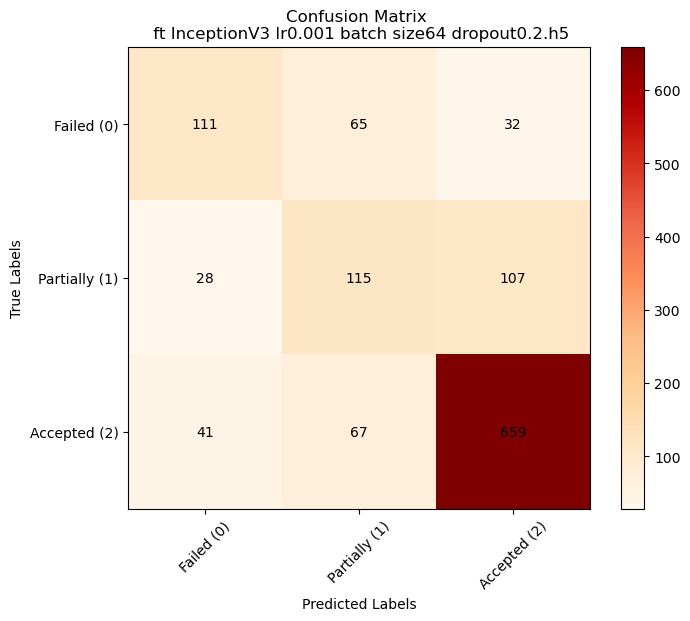

Running: 
 learning rate:0.001, batch size: 64 with dropout: 0.5 for epochs: 100
Epoch 1/100
212/212 [==============================] - 14s 49ms/step - loss: 2.9172 - accuracy: 0.4638 - val_loss: 1.9056 - val_accuracy: 0.2849
Epoch 2/100
212/212 [==============================] - 10s 45ms/step - loss: 1.0437 - accuracy: 0.5156 - val_loss: 1.2063 - val_accuracy: 0.4702
Epoch 3/100
212/212 [==============================] - 9s 44ms/step - loss: 0.9496 - accuracy: 0.5354 - val_loss: 1.2951 - val_accuracy: 0.4212
Epoch 4/100
212/212 [==============================] - 9s 44ms/step - loss: 0.9558 - accuracy: 0.5332 - val_loss: 1.7207 - val_accuracy: 0.3167
Epoch 5/100
212/212 [==============================] - 10s 46ms/step - loss: 0.9415 - accuracy: 0.5360 - val_loss: 1.0906 - val_accuracy: 0.5143
Epoch 6/100
212/212 [==============================] - 10s 46ms/step - loss: 0.9561 - accuracy: 0.5395 - val_loss: 1.1115 - val_accuracy: 0.5192
Epoch 7/100
212/212 [==============================

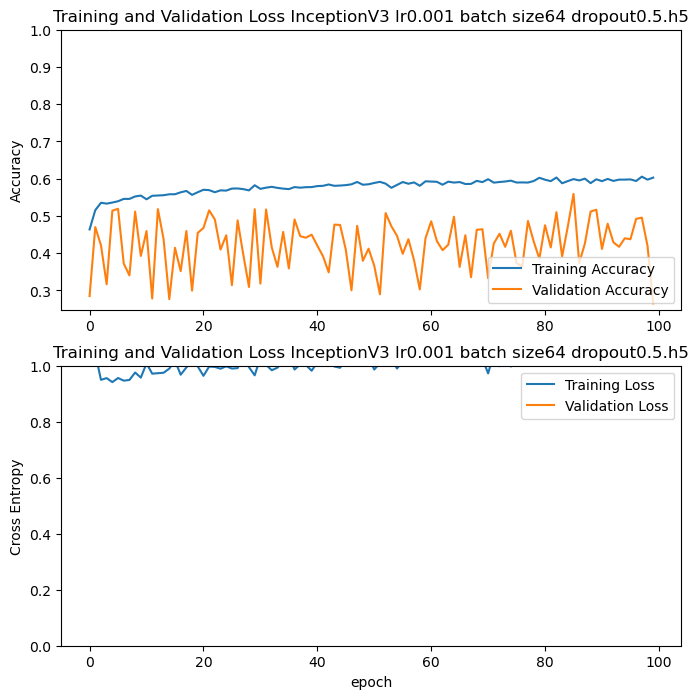

39/39 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       0.25      0.16      0.20       208
           1       0.28      0.28      0.28       250
           2       0.68      0.75      0.71       767

    accuracy                           0.55      1225
   macro avg       0.41      0.40      0.40      1225
weighted avg       0.53      0.55      0.54      1225



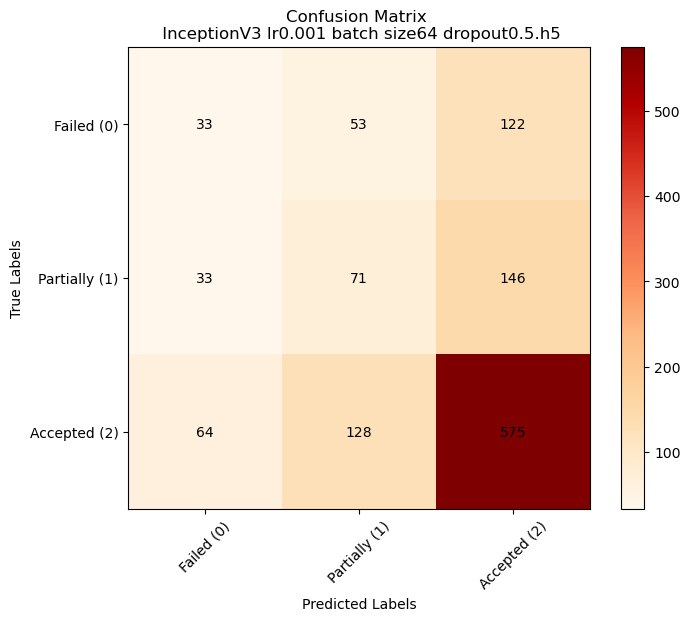

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

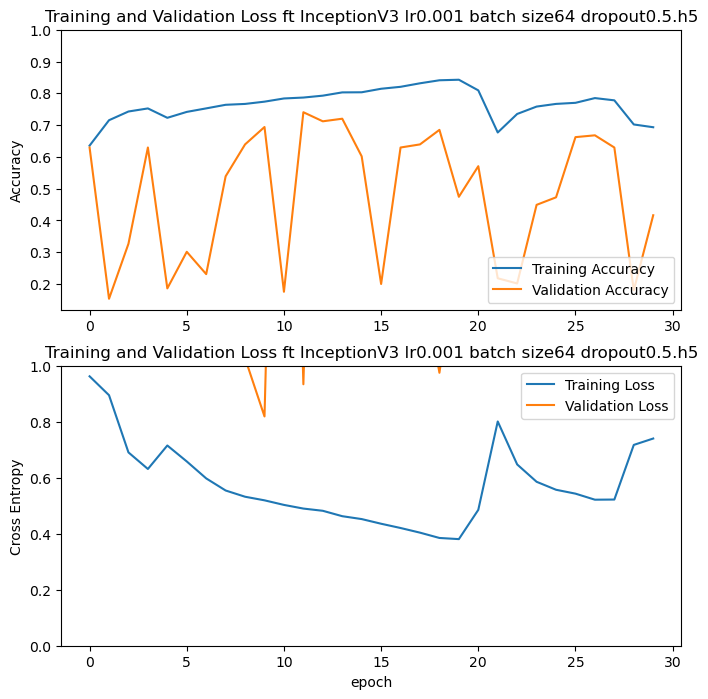

39/39 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       208
           1       0.51      0.44      0.47       250
           2       0.83      0.88      0.85       767

    accuracy                           0.75      1225
   macro avg       0.68      0.66      0.67      1225
weighted avg       0.74      0.75      0.75      1225



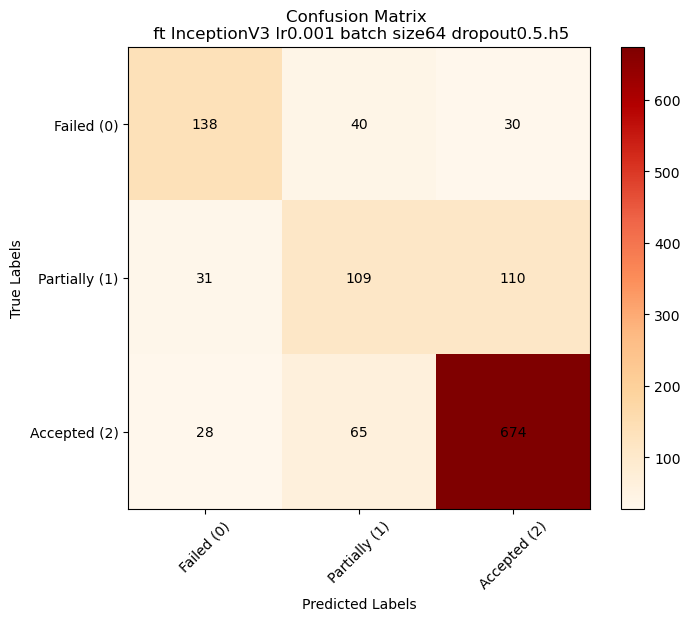

Running: 
 learning rate:0.001, batch size: 32 with dropout: 0.2 for epochs: 100
Epoch 1/100
424/424 [==============================] - 17s 32ms/step - loss: 1.7711 - accuracy: 0.4740 - val_loss: 1.1535 - val_accuracy: 0.4506
Epoch 2/100
424/424 [==============================] - 12s 28ms/step - loss: 0.9514 - accuracy: 0.5200 - val_loss: 1.3469 - val_accuracy: 0.3812
Epoch 3/100
424/424 [==============================] - 12s 29ms/step - loss: 0.9773 - accuracy: 0.5186 - val_loss: 1.1438 - val_accuracy: 0.5020
Epoch 4/100
424/424 [==============================] - 12s 28ms/step - loss: 0.9760 - accuracy: 0.5280 - val_loss: 1.4272 - val_accuracy: 0.3673
Epoch 5/100
424/424 [==============================] - 12s 28ms/step - loss: 0.9690 - accuracy: 0.5321 - val_loss: 1.5056 - val_accuracy: 0.3282
Epoch 6/100
424/424 [==============================] - 12s 28ms/step - loss: 0.9861 - accuracy: 0.5316 - val_loss: 1.8020 - val_accuracy: 0.2612
Epoch 7/100
424/424 [============================

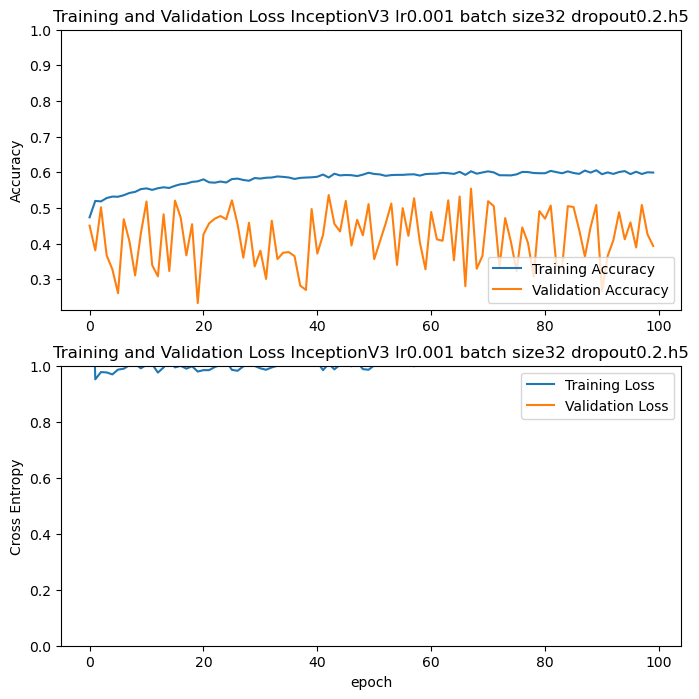

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.26      0.17      0.21       208
           1       0.25      0.23      0.24       250
           2       0.67      0.75      0.71       767

    accuracy                           0.55      1225
   macro avg       0.39      0.38      0.39      1225
weighted avg       0.52      0.55      0.53      1225



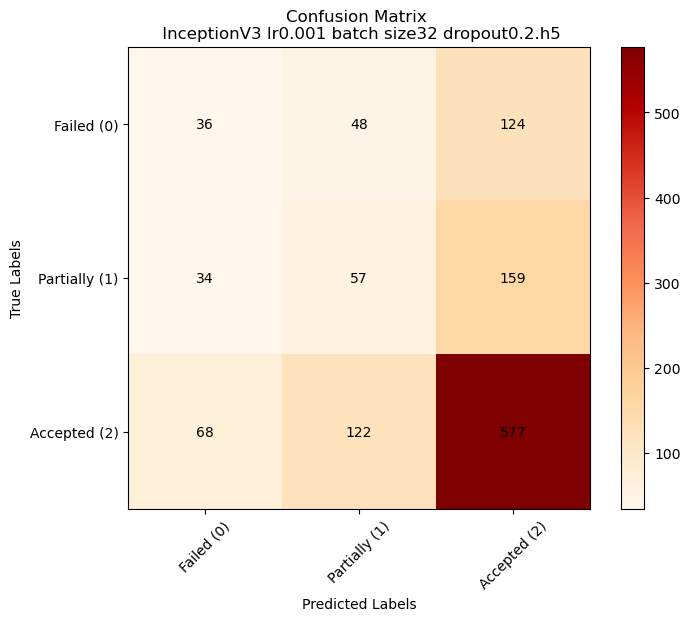

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

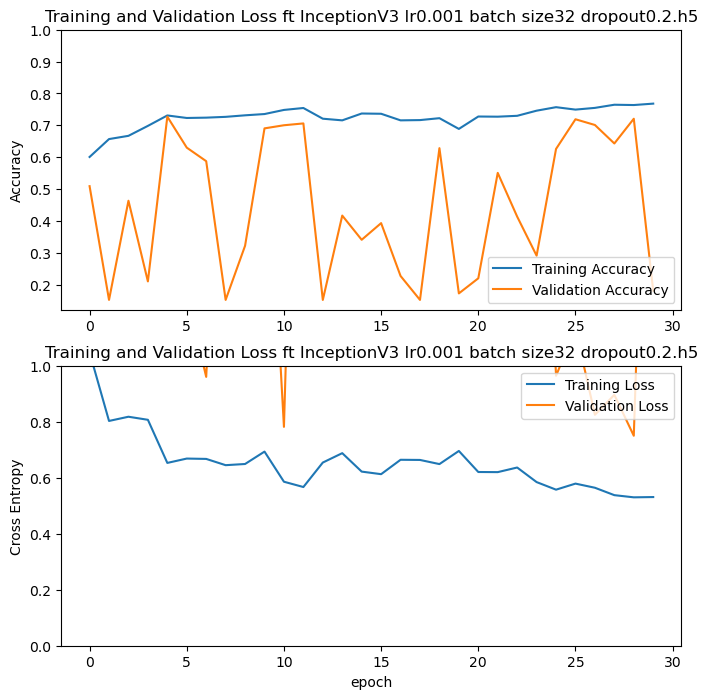

39/39 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       208
           1       0.56      0.11      0.18       250
           2       0.76      0.96      0.85       767

    accuracy                           0.74      1225
   macro avg       0.68      0.59      0.58      1225
weighted avg       0.71      0.74      0.69      1225



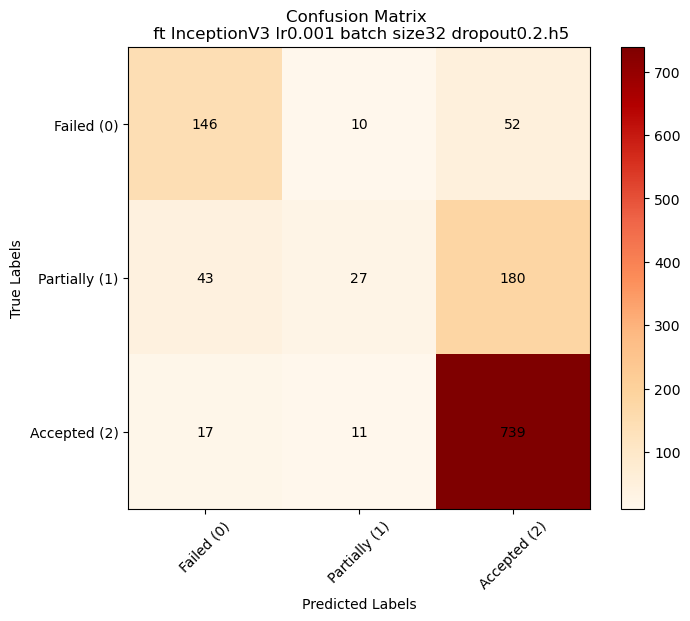

Running: 
 learning rate:0.001, batch size: 32 with dropout: 0.5 for epochs: 100
Epoch 1/100
424/424 [==============================] - 15s 30ms/step - loss: 2.3720 - accuracy: 0.4665 - val_loss: 1.4466 - val_accuracy: 0.4147
Epoch 2/100
424/424 [==============================] - 11s 27ms/step - loss: 1.0969 - accuracy: 0.5021 - val_loss: 1.5850 - val_accuracy: 0.3535
Epoch 3/100
424/424 [==============================] - 11s 27ms/step - loss: 1.0985 - accuracy: 0.5058 - val_loss: 1.6726 - val_accuracy: 0.3853
Epoch 4/100
424/424 [==============================] - 12s 28ms/step - loss: 1.1583 - accuracy: 0.5105 - val_loss: 1.4490 - val_accuracy: 0.4400
Epoch 5/100
424/424 [==============================] - 11s 27ms/step - loss: 1.1811 - accuracy: 0.5089 - val_loss: 2.1339 - val_accuracy: 0.2914
Epoch 6/100
424/424 [==============================] - 12s 28ms/step - loss: 1.2353 - accuracy: 0.5153 - val_loss: 1.2844 - val_accuracy: 0.5404
Epoch 7/100
424/424 [============================

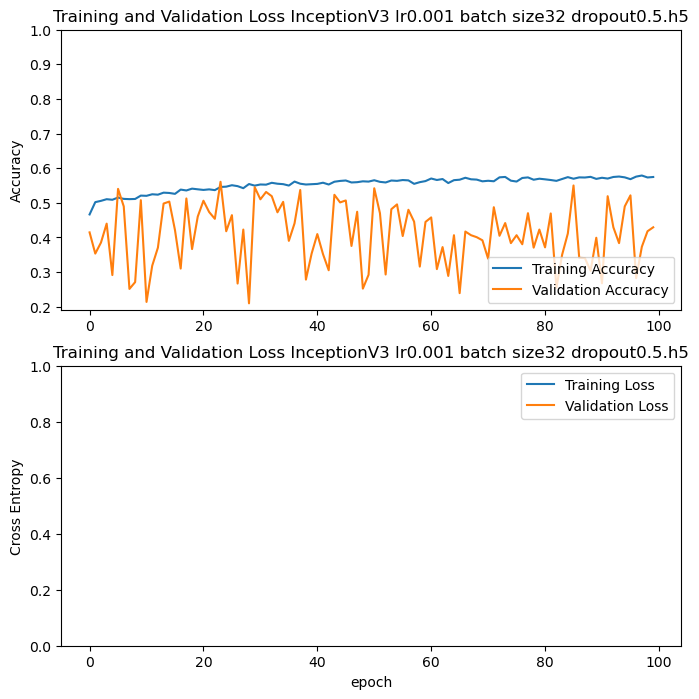

39/39 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

           0       0.25      0.22      0.24       208
           1       0.26      0.19      0.22       250
           2       0.67      0.76      0.71       767

    accuracy                           0.55      1225
   macro avg       0.40      0.39      0.39      1225
weighted avg       0.52      0.55      0.53      1225



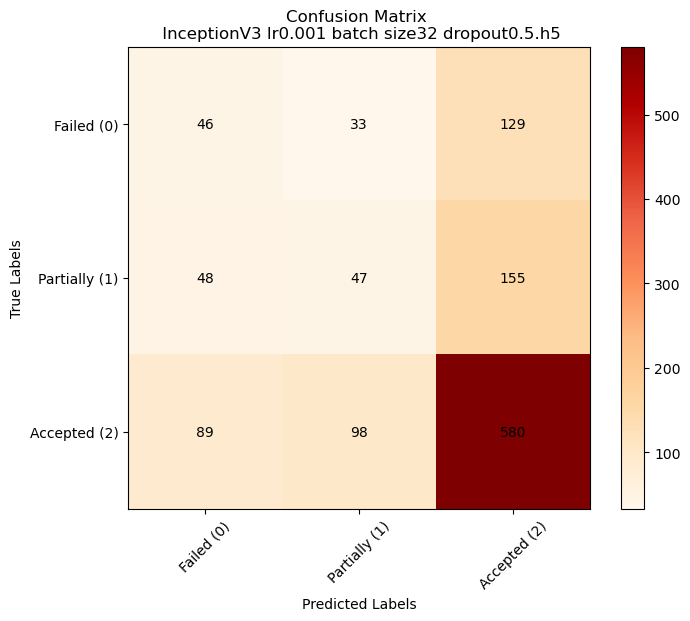

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

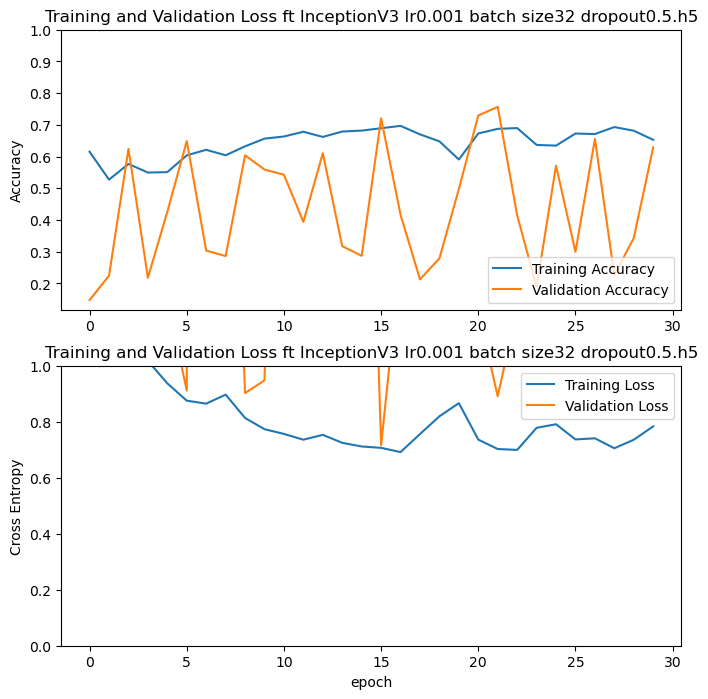

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       208
           1       0.53      0.42      0.47       250
           2       0.83      0.91      0.87       767

    accuracy                           0.77      1225
   macro avg       0.71      0.67      0.68      1225
weighted avg       0.76      0.77      0.76      1225



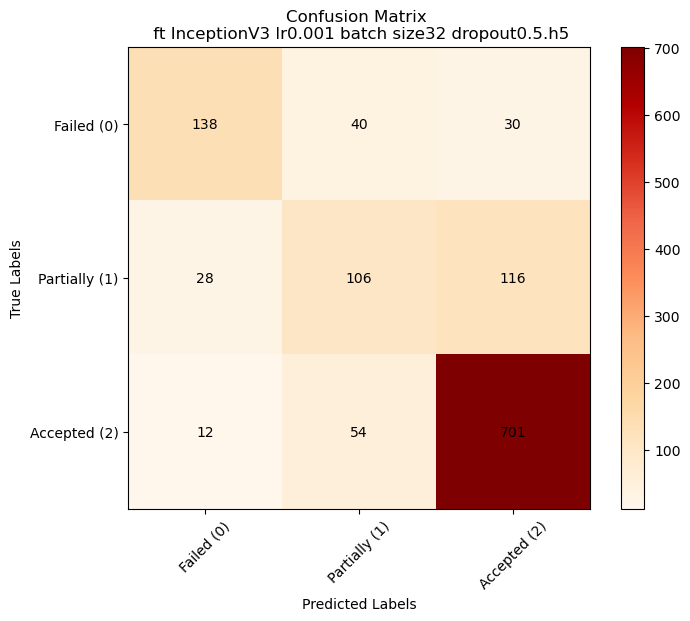

Running: 
 learning rate:0.001, batch size: 16 with dropout: 0.2 for epochs: 100
Epoch 1/100
848/848 [==============================] - 20s 21ms/step - loss: 1.7116 - accuracy: 0.4669 - val_loss: 1.2819 - val_accuracy: 0.4833
Epoch 2/100
848/848 [==============================] - 17s 20ms/step - loss: 1.1116 - accuracy: 0.4872 - val_loss: 1.4721 - val_accuracy: 0.3812
Epoch 3/100
848/848 [==============================] - 17s 20ms/step - loss: 1.1663 - accuracy: 0.4965 - val_loss: 1.5573 - val_accuracy: 0.3886
Epoch 4/100
848/848 [==============================] - 17s 20ms/step - loss: 1.2257 - accuracy: 0.5031 - val_loss: 1.4316 - val_accuracy: 0.4678
Epoch 5/100
848/848 [==============================] - 17s 20ms/step - loss: 1.2156 - accuracy: 0.5100 - val_loss: 2.7795 - val_accuracy: 0.2735
Epoch 6/100
848/848 [==============================] - 17s 20ms/step - loss: 1.2645 - accuracy: 0.5063 - val_loss: 1.8011 - val_accuracy: 0.3845
Epoch 7/100
848/848 [============================

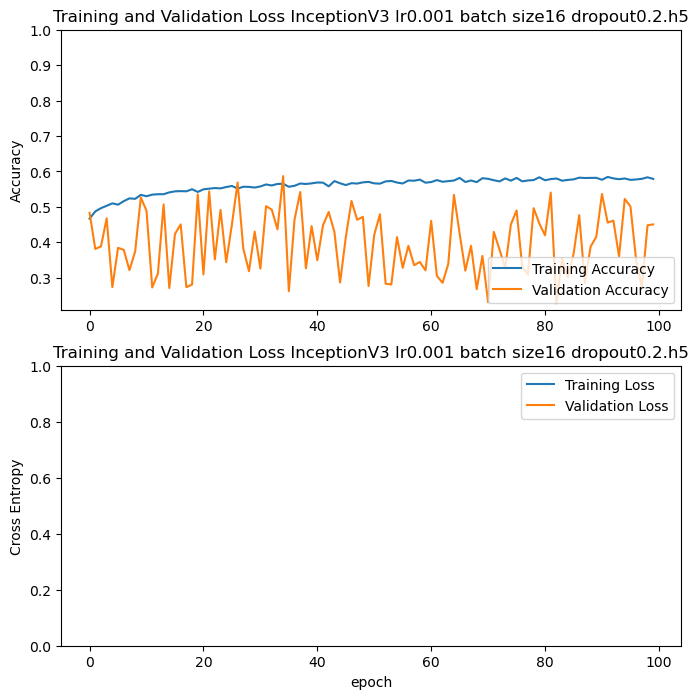

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.24      0.22      0.23       208
           1       0.16      0.03      0.05       250
           2       0.66      0.85      0.74       767

    accuracy                           0.58      1225
   macro avg       0.36      0.37      0.34      1225
weighted avg       0.49      0.58      0.52      1225



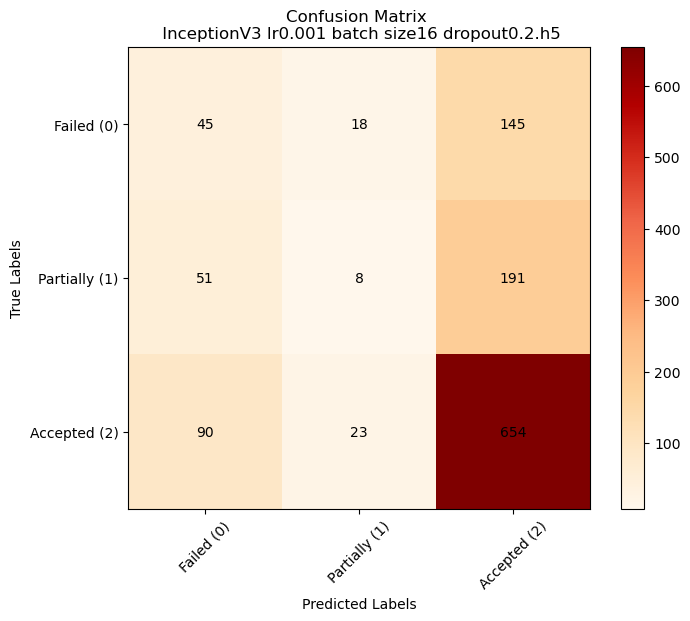

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

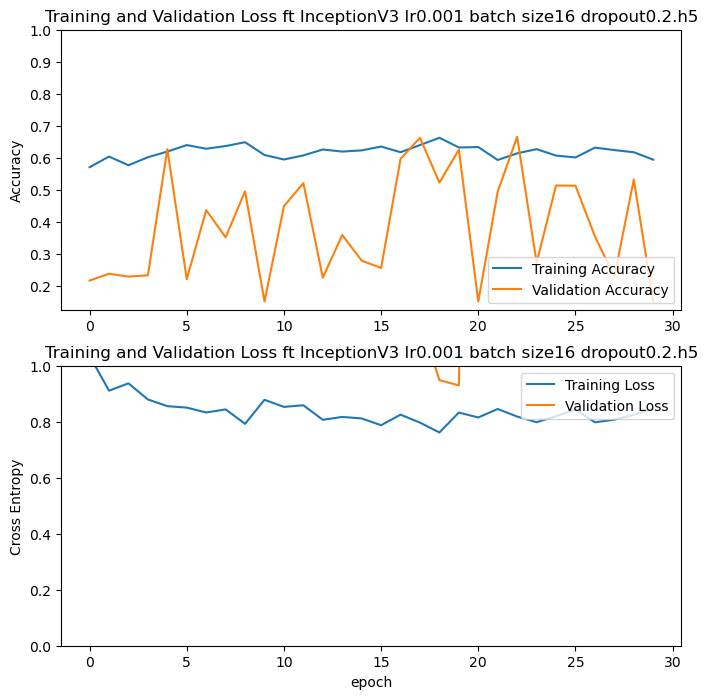

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.72      0.48      0.57       208
           1       0.33      0.54      0.41       250
           2       0.83      0.73      0.78       767

    accuracy                           0.65      1225
   macro avg       0.62      0.58      0.59      1225
weighted avg       0.71      0.65      0.67      1225



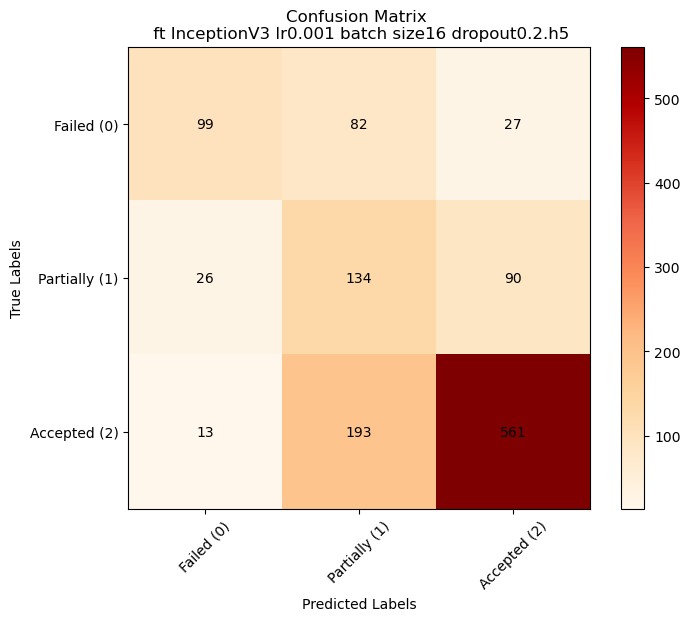

Running: 
 learning rate:0.001, batch size: 16 with dropout: 0.5 for epochs: 100
Epoch 1/100
848/848 [==============================] - 20s 21ms/step - loss: 2.4300 - accuracy: 0.4585 - val_loss: 1.3968 - val_accuracy: 0.4163
Epoch 2/100
848/848 [==============================] - 17s 20ms/step - loss: 1.5169 - accuracy: 0.4729 - val_loss: 1.4056 - val_accuracy: 0.5314
Epoch 3/100
848/848 [==============================] - 17s 20ms/step - loss: 1.6744 - accuracy: 0.4802 - val_loss: 3.1112 - val_accuracy: 0.3412
Epoch 4/100
848/848 [==============================] - 17s 20ms/step - loss: 1.9408 - accuracy: 0.4805 - val_loss: 4.1675 - val_accuracy: 0.2743
Epoch 5/100
848/848 [==============================] - 17s 20ms/step - loss: 1.9571 - accuracy: 0.4866 - val_loss: 2.0425 - val_accuracy: 0.4694
Epoch 6/100
848/848 [==============================] - 17s 20ms/step - loss: 2.1018 - accuracy: 0.4944 - val_loss: 4.7733 - val_accuracy: 0.2033
Epoch 7/100
848/848 [============================

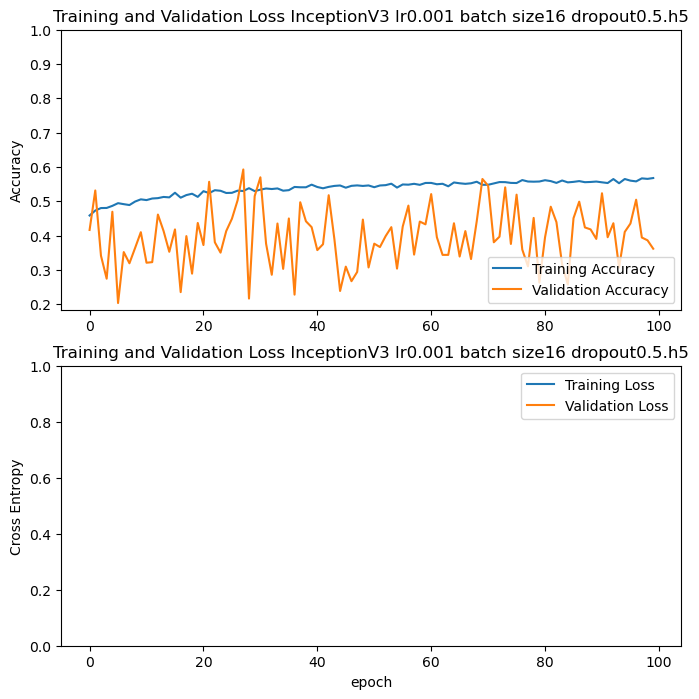

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.31      0.19      0.24       208
           1       0.29      0.06      0.10       250
           2       0.66      0.90      0.76       767

    accuracy                           0.61      1225
   macro avg       0.42      0.38      0.37      1225
weighted avg       0.53      0.61      0.54      1225



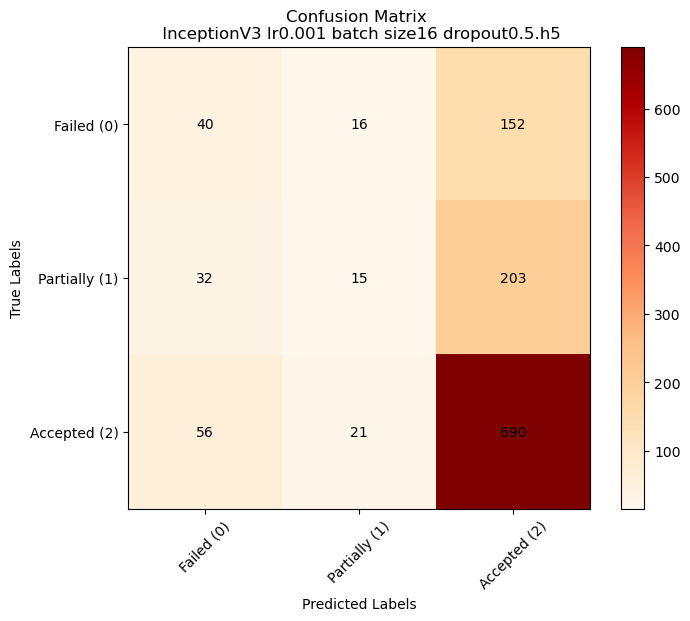

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_13 (Dense)            (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

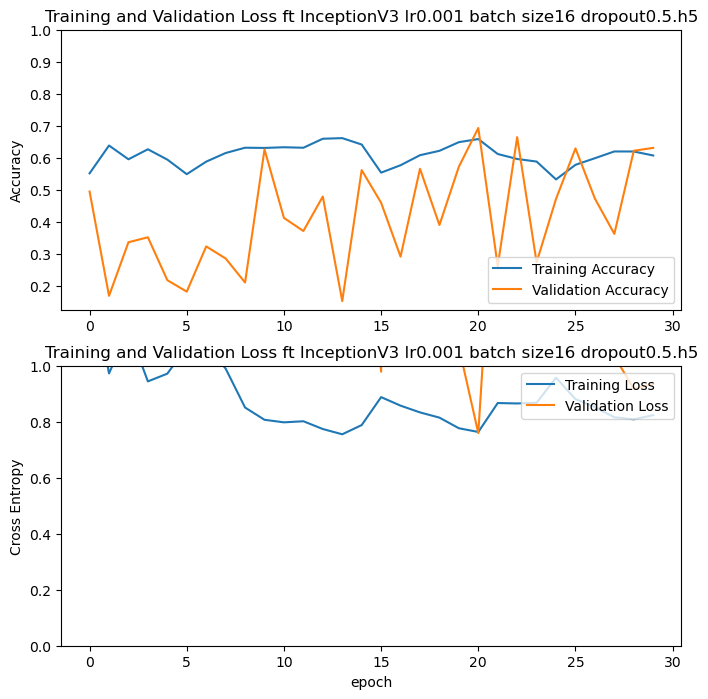

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.71      0.55      0.62       208
           1       0.40      0.48      0.44       250
           2       0.83      0.83      0.83       767

    accuracy                           0.71      1225
   macro avg       0.65      0.62      0.63      1225
weighted avg       0.72      0.71      0.71      1225



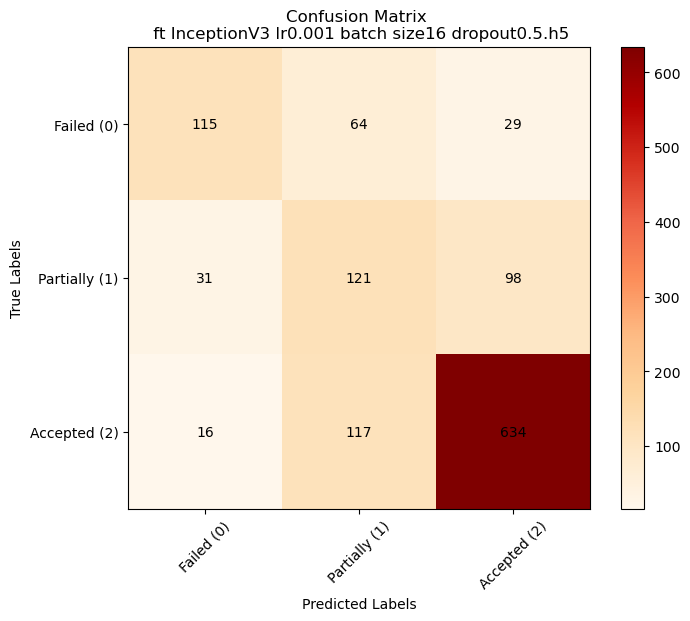

In [17]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.001]
batch_size = [64,32,16]
dropouts = [0.2, 0.5]

####################################################################################################################
#           We define our model specific parameters

model_name = "InceptionV3" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running {len(learning_rate)*len(batch_size)*len(dropouts)} possible models with learning rates:{learning_rate} and batch sizes: {batch_size} with dropouts: {dropouts} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
        for d in dropouts:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} with dropout: {d} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.InceptionV3(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(2048, activation='linear'),  
                tf.keras.layers.Dropout(d),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  


            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  


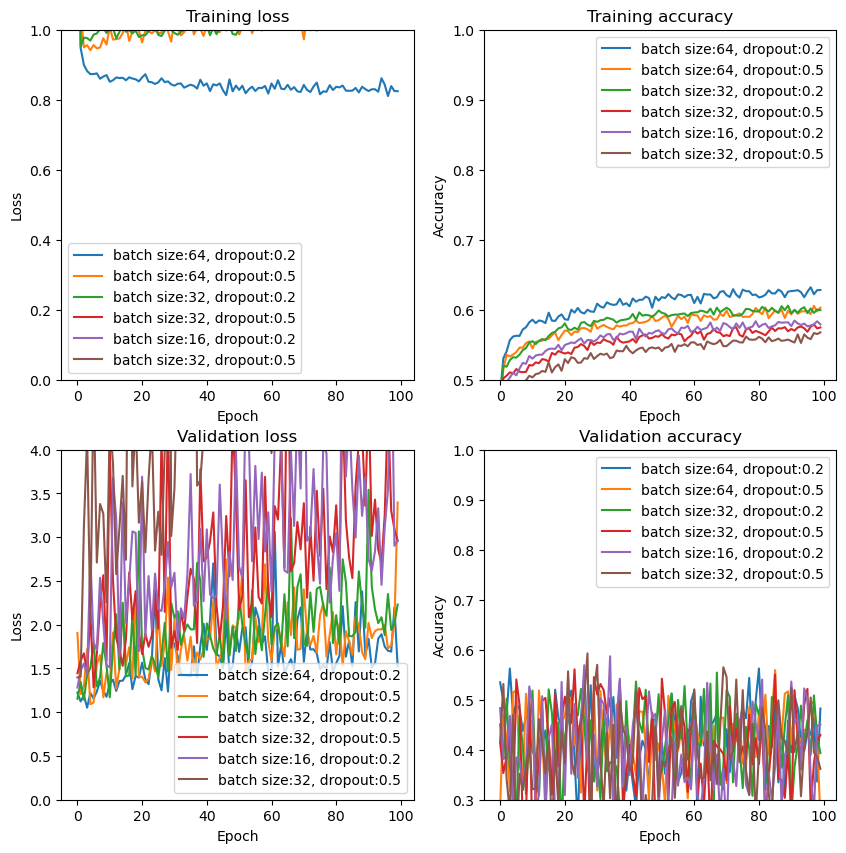

In [18]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['loss'], label='batch size:32, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['accuracy'], label='batch size:32, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_accuracy'], label='batch size:32, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()

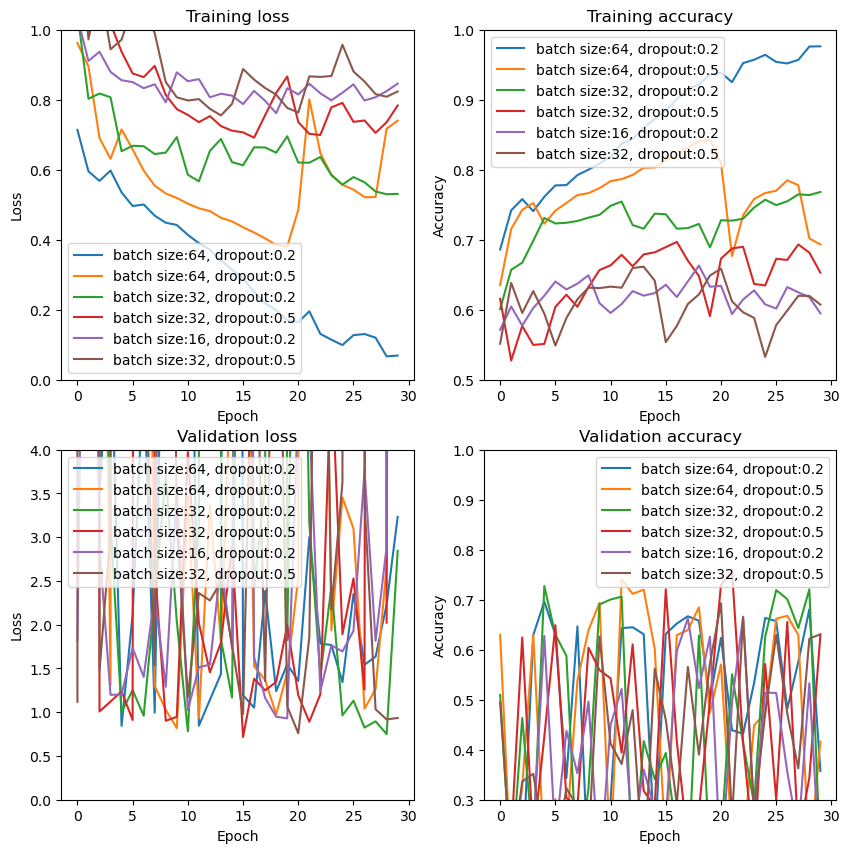

In [19]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(ft_histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['loss'], label='batch size:32, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(ft_histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['accuracy'], label='batch size:32, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(ft_histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(ft_histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_accuracy'], label='batch size:32, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()

### For 0.01 learning rate

In [20]:
histories = []
name = []

ft_histories = []
ft_name = []

Running 6 possible models with learning rates:[0.01] and batch sizes: [64, 32, 16] with dropouts: [0.2, 0.5] for epochs: 100
Running: 
 learning rate:0.01, batch size: 64 with dropout: 0.2 for epochs: 100
Epoch 1/100
212/212 [==============================] - 19s 50ms/step - loss: 7.5787 - accuracy: 0.4357 - val_loss: 3.0619 - val_accuracy: 0.2653
Epoch 2/100
212/212 [==============================] - 9s 44ms/step - loss: 6.7885 - accuracy: 0.4414 - val_loss: 8.3754 - val_accuracy: 0.2702
Epoch 3/100
212/212 [==============================] - 9s 43ms/step - loss: 11.4324 - accuracy: 0.4486 - val_loss: 19.2334 - val_accuracy: 0.2327
Epoch 4/100
212/212 [==============================] - 9s 43ms/step - loss: 9.7387 - accuracy: 0.4703 - val_loss: 35.8020 - val_accuracy: 0.2180
Epoch 5/100
212/212 [==============================] - 9s 43ms/step - loss: 12.9986 - accuracy: 0.4720 - val_loss: 37.5629 - val_accuracy: 0.1935
Epoch 6/100
212/212 [==============================] - 9s 42ms/step -

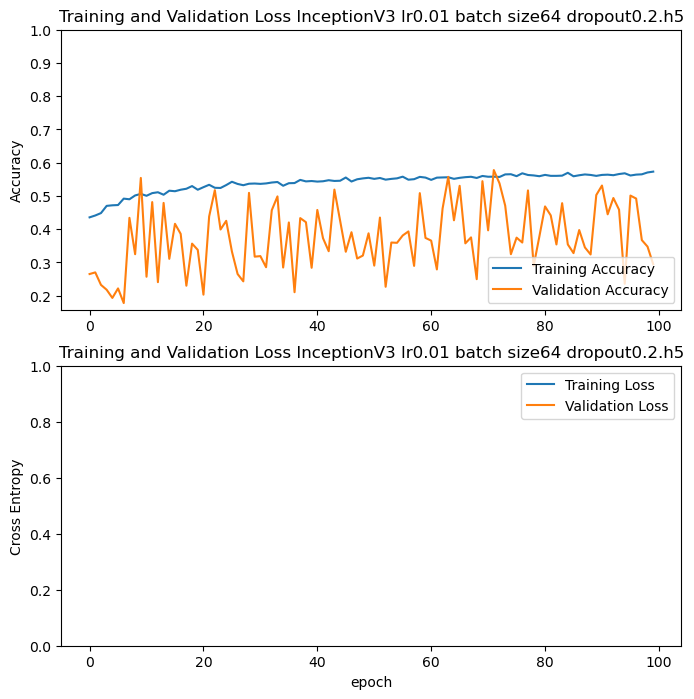

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.25      0.15      0.19       208
           1       0.28      0.20      0.23       250
           2       0.66      0.80      0.72       767

    accuracy                           0.56      1225
   macro avg       0.40      0.38      0.38      1225
weighted avg       0.52      0.56      0.53      1225



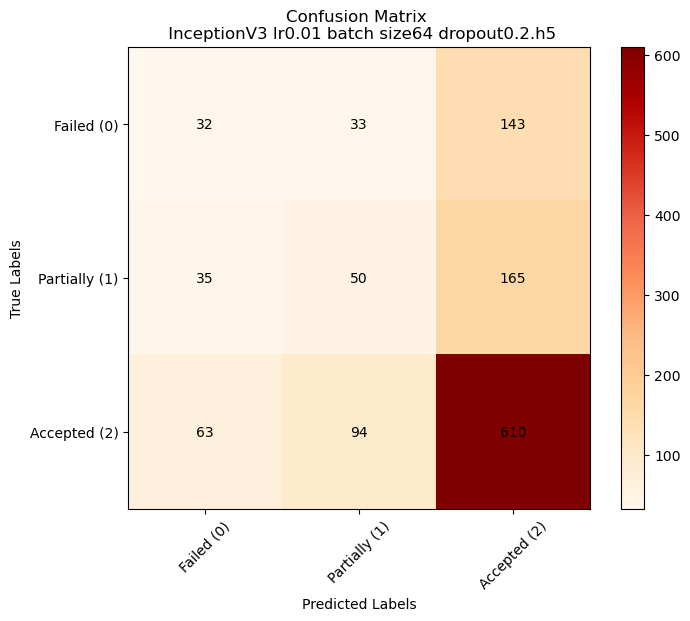

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_______________________________________

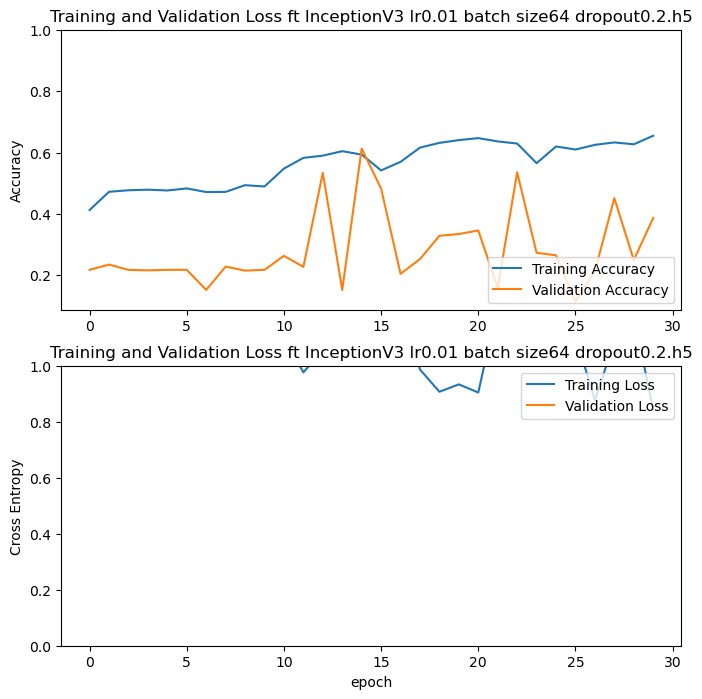

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.28      0.02      0.04       208
           1       0.12      0.01      0.02       250
           2       0.62      0.96      0.76       767

    accuracy                           0.61      1225
   macro avg       0.34      0.33      0.27      1225
weighted avg       0.46      0.61      0.49      1225



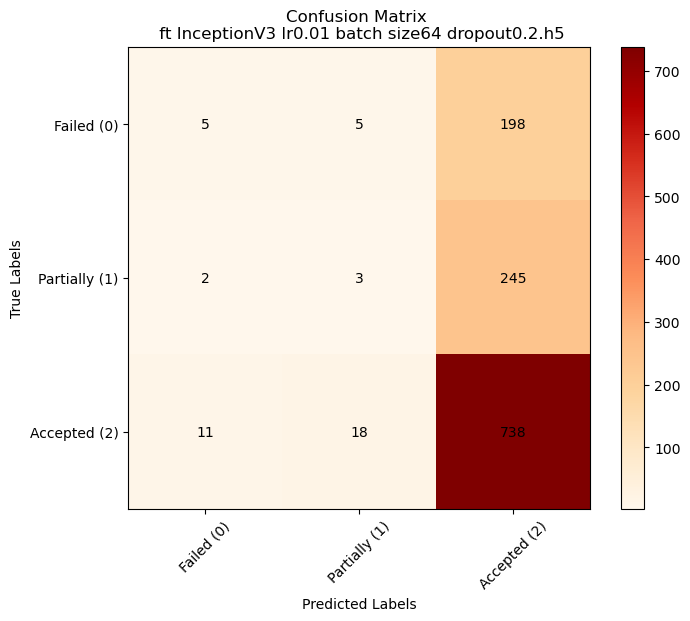

Running: 
 learning rate:0.01, batch size: 64 with dropout: 0.5 for epochs: 100
Epoch 1/100
212/212 [==============================] - 13s 48ms/step - loss: 15.0393 - accuracy: 0.4222 - val_loss: 6.1704 - val_accuracy: 0.3927
Epoch 2/100
212/212 [==============================] - 9s 42ms/step - loss: 13.6281 - accuracy: 0.4284 - val_loss: 44.5869 - val_accuracy: 0.2139
Epoch 3/100
212/212 [==============================] - 9s 43ms/step - loss: 24.2855 - accuracy: 0.4608 - val_loss: 22.2849 - val_accuracy: 0.4776
Epoch 4/100
212/212 [==============================] - 9s 42ms/step - loss: 30.3967 - accuracy: 0.4633 - val_loss: 60.0216 - val_accuracy: 0.2669
Epoch 5/100
212/212 [==============================] - 9s 43ms/step - loss: 29.7608 - accuracy: 0.4713 - val_loss: 29.7097 - val_accuracy: 0.5469
Epoch 6/100
212/212 [==============================] - 9s 42ms/step - loss: 31.6274 - accuracy: 0.4763 - val_loss: 47.7213 - val_accuracy: 0.3445
Epoch 7/100
212/212 [=======================

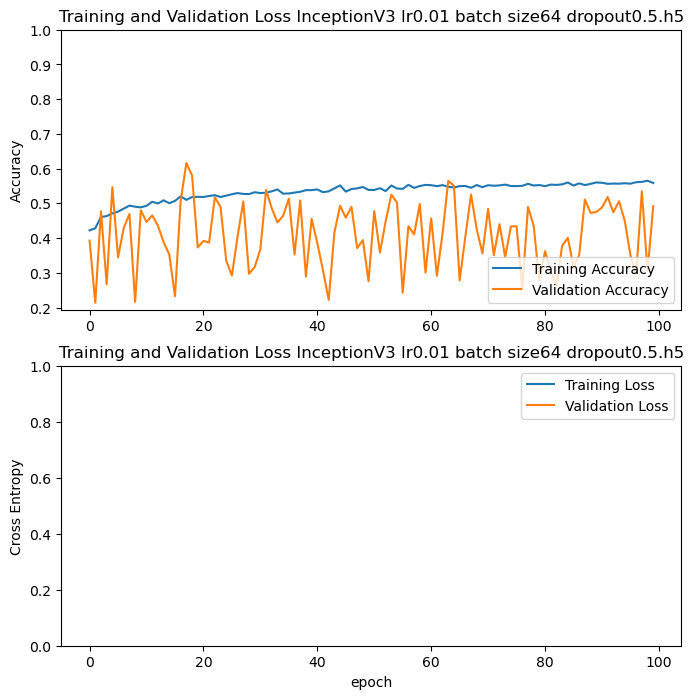

39/39 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       0.28      0.08      0.12       208
           1       0.24      0.07      0.11       250
           2       0.65      0.93      0.76       767

    accuracy                           0.61      1225
   macro avg       0.39      0.36      0.33      1225
weighted avg       0.50      0.61      0.52      1225



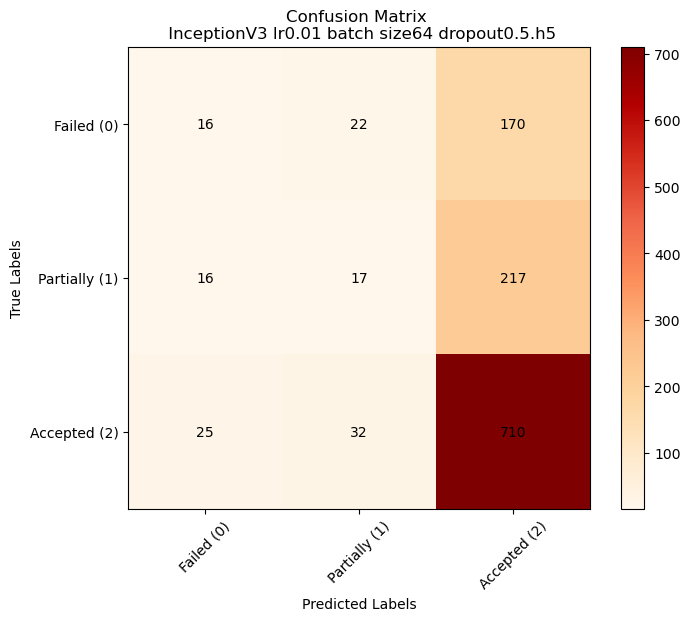

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

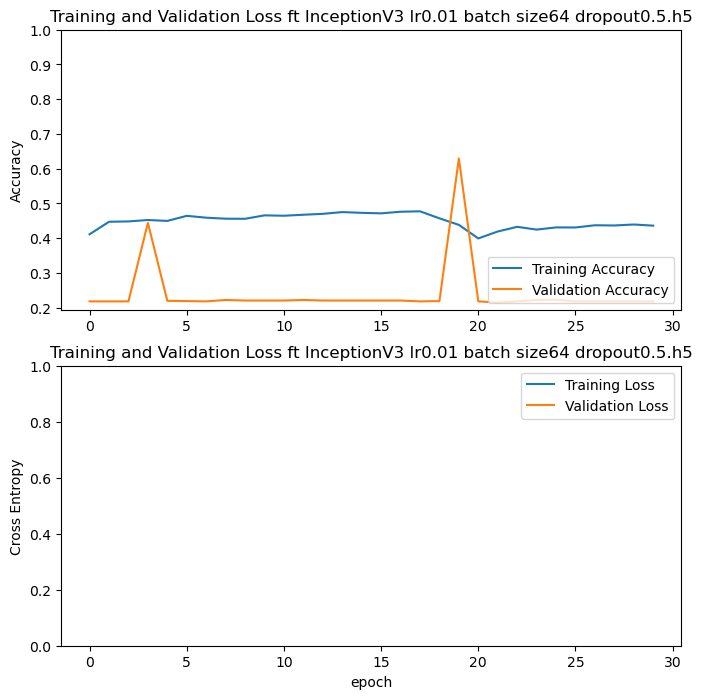

39/39 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.00      0.00      0.00       250
           2       0.63      1.00      0.77       767

    accuracy                           0.63      1225
   macro avg       0.21      0.33      0.26      1225
weighted avg       0.39      0.63      0.48      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


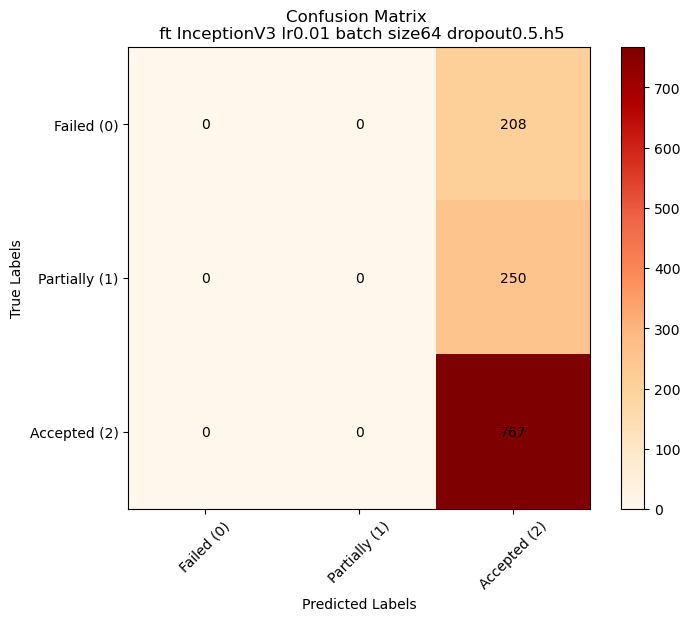

Running: 
 learning rate:0.01, batch size: 32 with dropout: 0.2 for epochs: 100
Epoch 1/100
424/424 [==============================] - 15s 29ms/step - loss: 10.3415 - accuracy: 0.4218 - val_loss: 12.1146 - val_accuracy: 0.3331
Epoch 2/100
424/424 [==============================] - 11s 26ms/step - loss: 23.2926 - accuracy: 0.4379 - val_loss: 55.5044 - val_accuracy: 0.3029
Epoch 3/100
424/424 [==============================] - 11s 27ms/step - loss: 32.6738 - accuracy: 0.4571 - val_loss: 44.4264 - val_accuracy: 0.3886
Epoch 4/100
424/424 [==============================] - 11s 26ms/step - loss: 33.5455 - accuracy: 0.4706 - val_loss: 47.8695 - val_accuracy: 0.3551
Epoch 5/100
424/424 [==============================] - 11s 27ms/step - loss: 33.0550 - accuracy: 0.4841 - val_loss: 51.6320 - val_accuracy: 0.3959
Epoch 6/100
424/424 [==============================] - 11s 27ms/step - loss: 37.0714 - accuracy: 0.4821 - val_loss: 37.2492 - val_accuracy: 0.5167
Epoch 7/100
424/424 [=================

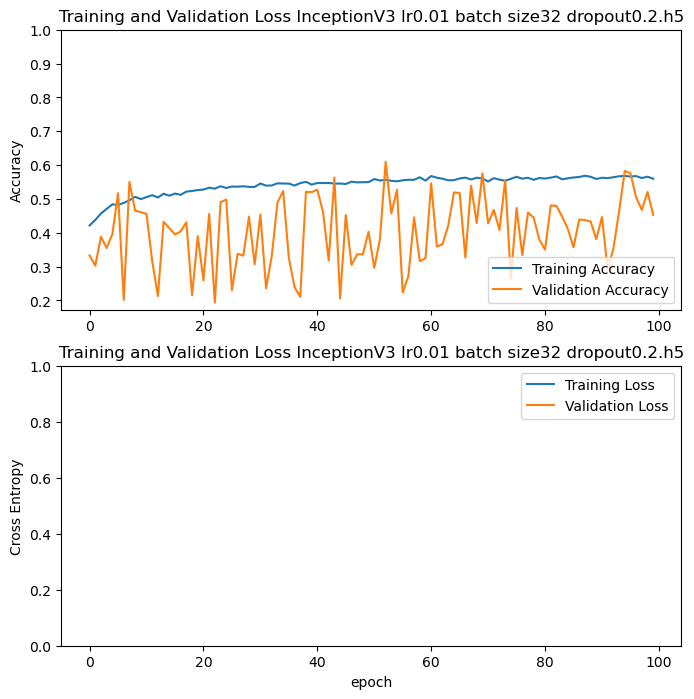

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.34      0.11      0.16       208
           1       0.34      0.14      0.20       250
           2       0.65      0.90      0.75       767

    accuracy                           0.61      1225
   macro avg       0.44      0.38      0.37      1225
weighted avg       0.53      0.61      0.54      1225



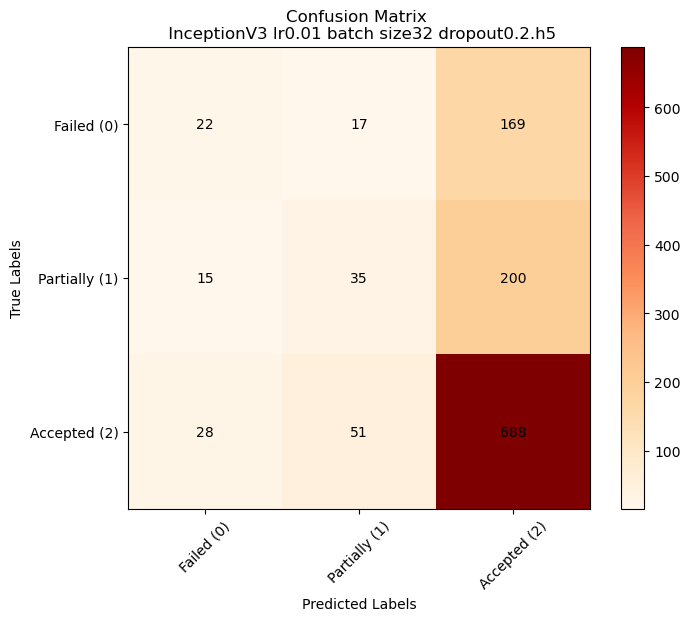

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

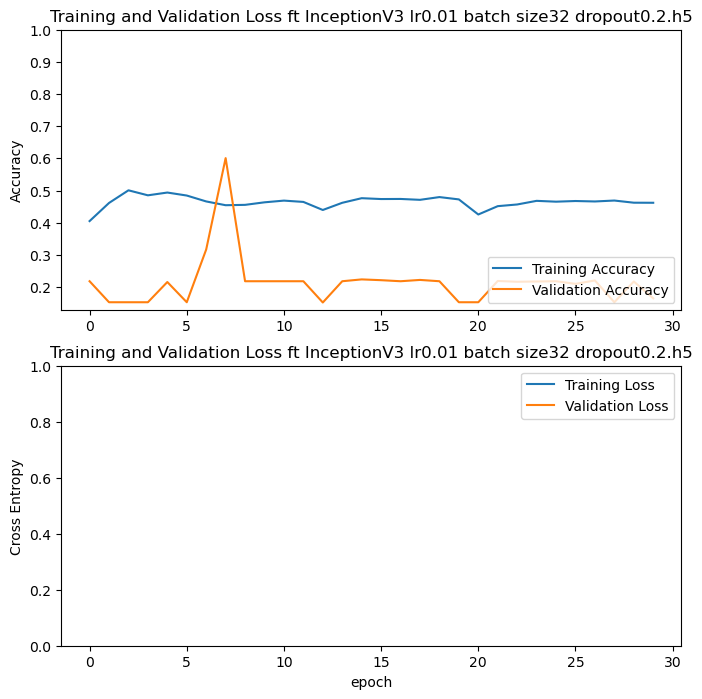

39/39 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.10      0.03      0.05       250
           2       0.61      0.91      0.73       767

    accuracy                           0.58      1225
   macro avg       0.24      0.31      0.26      1225
weighted avg       0.40      0.58      0.47      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


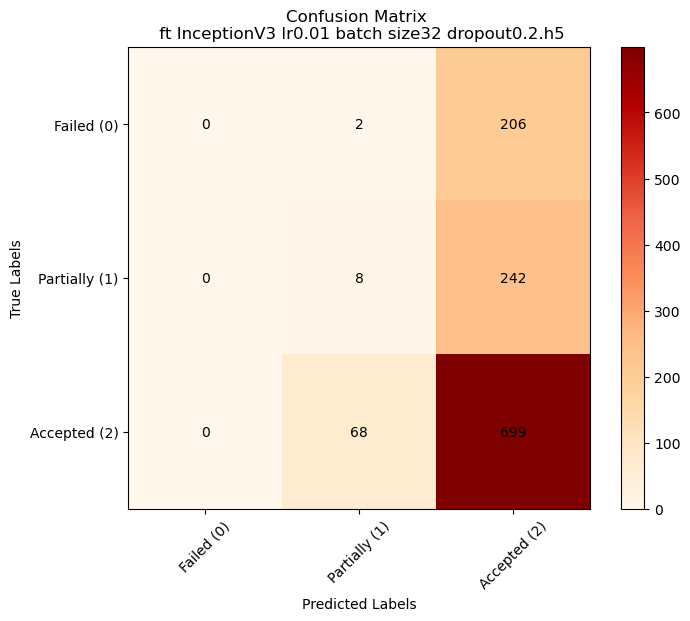

Running: 
 learning rate:0.01, batch size: 32 with dropout: 0.5 for epochs: 100
Epoch 1/100
424/424 [==============================] - 16s 30ms/step - loss: 39.7856 - accuracy: 0.4242 - val_loss: 90.1354 - val_accuracy: 0.3004
Epoch 2/100
424/424 [==============================] - 12s 27ms/step - loss: 68.2407 - accuracy: 0.4387 - val_loss: 42.6718 - val_accuracy: 0.5592
Epoch 3/100
424/424 [==============================] - 11s 27ms/step - loss: 67.7837 - accuracy: 0.4622 - val_loss: 154.6322 - val_accuracy: 0.2653
Epoch 4/100
424/424 [==============================] - 11s 27ms/step - loss: 77.1149 - accuracy: 0.4682 - val_loss: 155.5055 - val_accuracy: 0.2318
Epoch 5/100
424/424 [==============================] - 11s 27ms/step - loss: 79.6494 - accuracy: 0.4757 - val_loss: 89.5266 - val_accuracy: 0.4033
Epoch 6/100
424/424 [==============================] - 11s 27ms/step - loss: 85.6975 - accuracy: 0.4748 - val_loss: 144.1951 - val_accuracy: 0.2841
Epoch 7/100
424/424 [==============

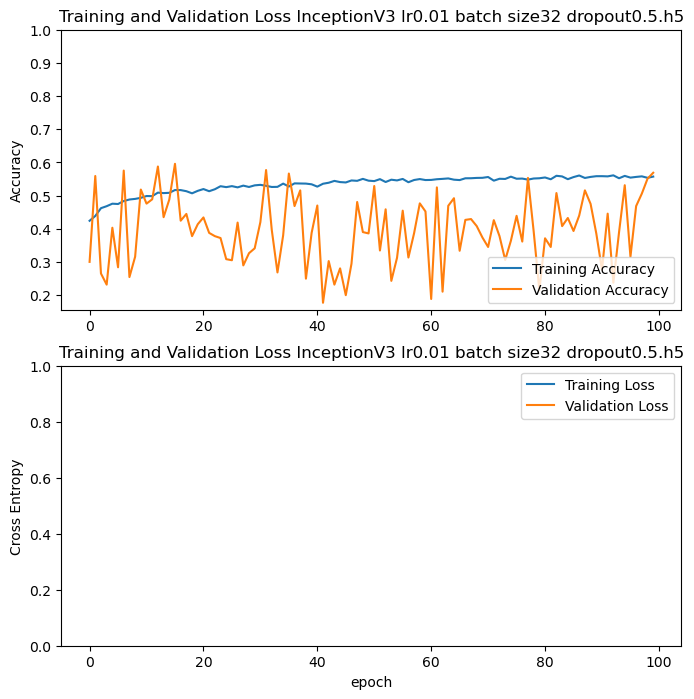

39/39 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       0.29      0.22      0.25       208
           1       0.35      0.08      0.13       250
           2       0.67      0.88      0.76       767

    accuracy                           0.60      1225
   macro avg       0.44      0.39      0.38      1225
weighted avg       0.54      0.60      0.54      1225



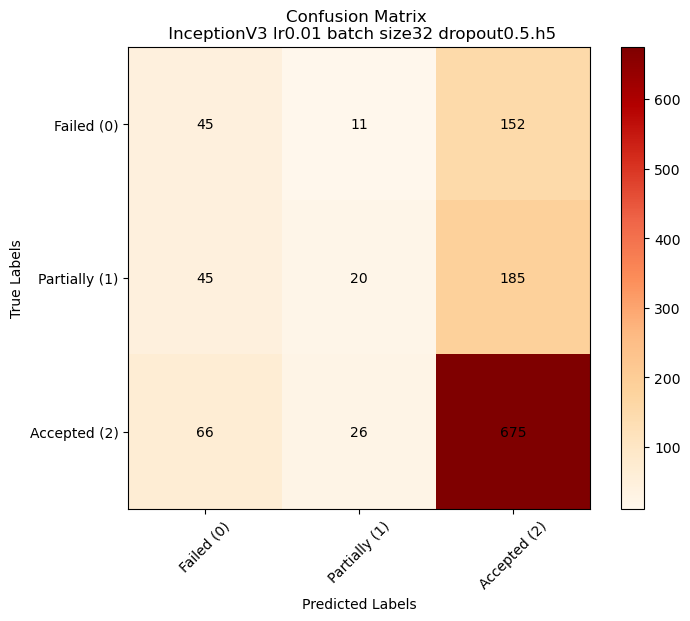

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

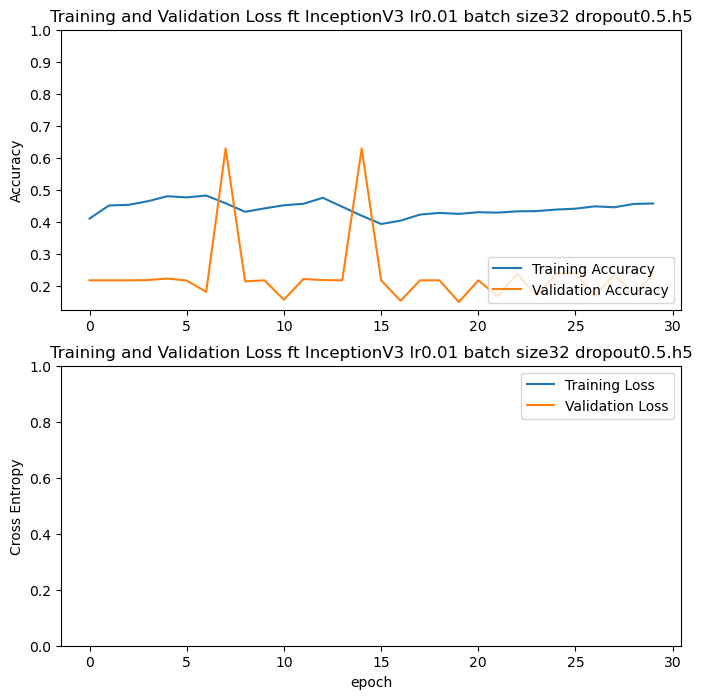

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.00      0.00      0.00       250
           2       0.63      1.00      0.77       767

    accuracy                           0.63      1225
   macro avg       0.21      0.33      0.26      1225
weighted avg       0.39      0.63      0.48      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


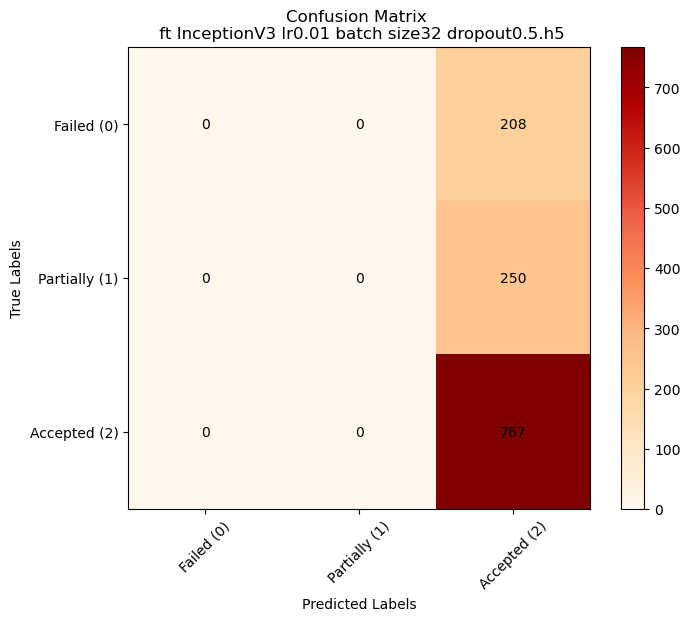

Running: 
 learning rate:0.01, batch size: 16 with dropout: 0.2 for epochs: 100
Epoch 1/100
848/848 [==============================] - 21s 21ms/step - loss: 42.6215 - accuracy: 0.4266 - val_loss: 42.5960 - val_accuracy: 0.4571
Epoch 2/100
848/848 [==============================] - 17s 20ms/step - loss: 68.0067 - accuracy: 0.4440 - val_loss: 61.8986 - val_accuracy: 0.4939
Epoch 3/100
848/848 [==============================] - 17s 20ms/step - loss: 71.5093 - accuracy: 0.4627 - val_loss: 81.6194 - val_accuracy: 0.4424
Epoch 4/100
848/848 [==============================] - 17s 20ms/step - loss: 77.8009 - accuracy: 0.4720 - val_loss: 140.0837 - val_accuracy: 0.2939
Epoch 5/100
848/848 [==============================] - 17s 20ms/step - loss: 79.2461 - accuracy: 0.4859 - val_loss: 61.7411 - val_accuracy: 0.5004
Epoch 6/100
848/848 [==============================] - 17s 20ms/step - loss: 78.7115 - accuracy: 0.4823 - val_loss: 78.0882 - val_accuracy: 0.5314
Epoch 7/100
848/848 [================

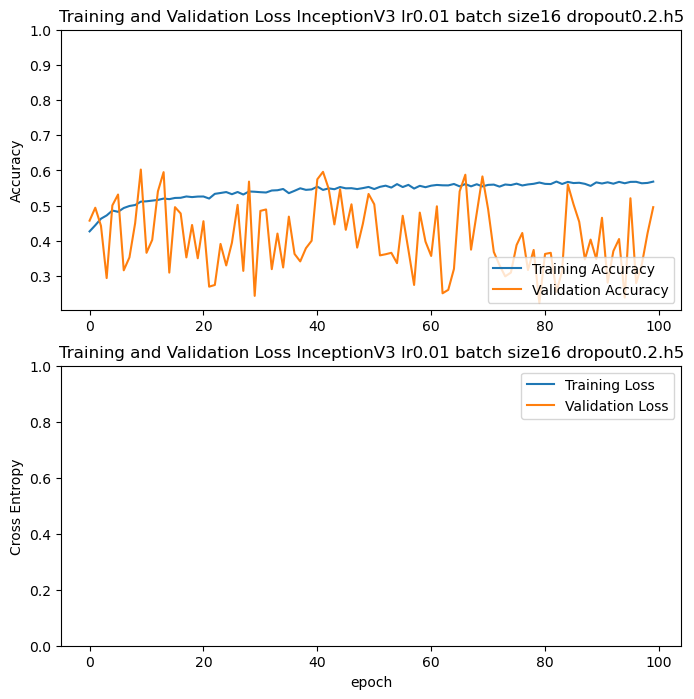

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.28      0.18      0.22       250
           2       0.64      0.89      0.75       767

    accuracy                           0.60      1225
   macro avg       0.31      0.36      0.32      1225
weighted avg       0.46      0.60      0.51      1225



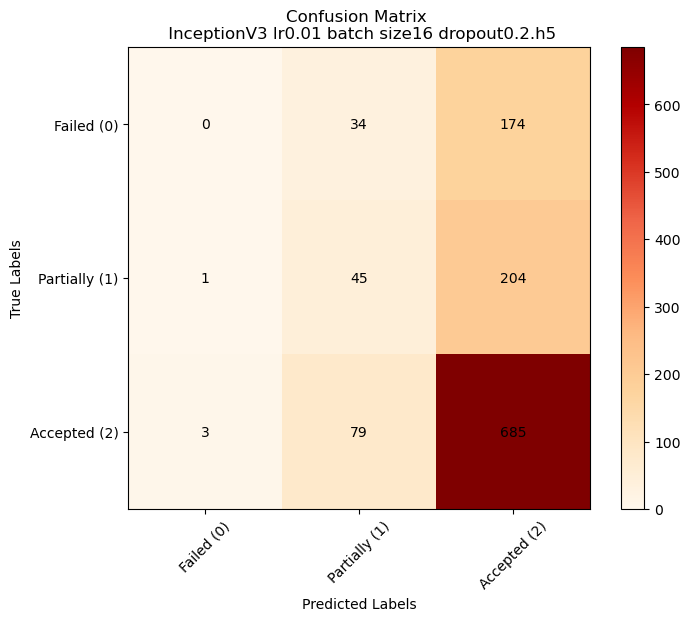

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

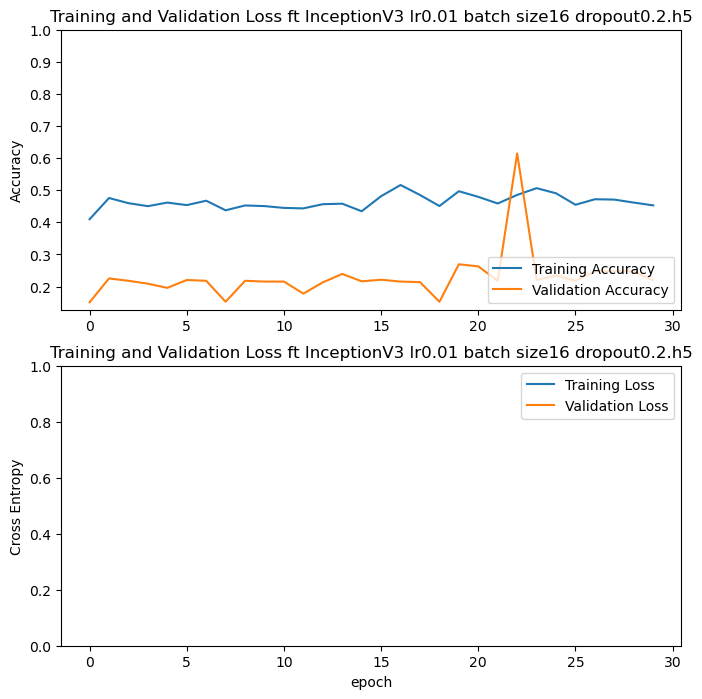

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.06      0.01      0.02       208
           1       0.00      0.00      0.00       250
           2       0.62      0.96      0.75       767

    accuracy                           0.60      1225
   macro avg       0.23      0.32      0.26      1225
weighted avg       0.40      0.60      0.47      1225



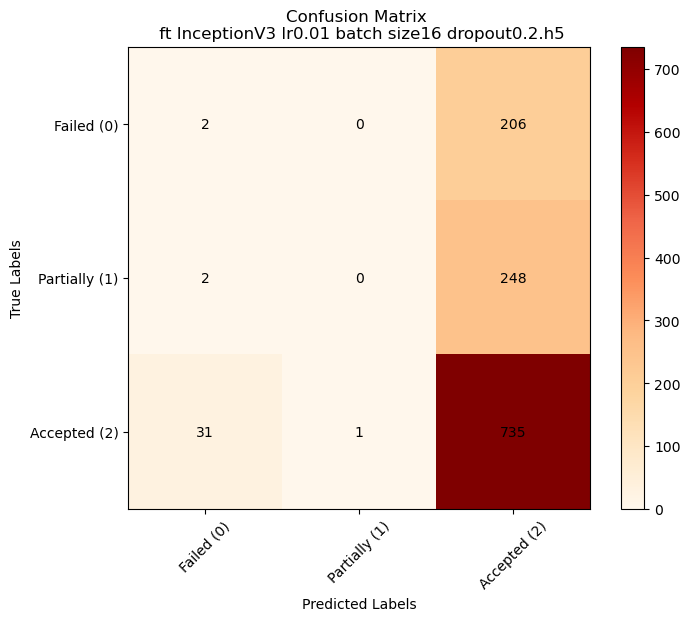

Running: 
 learning rate:0.01, batch size: 16 with dropout: 0.5 for epochs: 100
Epoch 1/100
848/848 [==============================] - 20s 20ms/step - loss: 113.7155 - accuracy: 0.4270 - val_loss: 156.0055 - val_accuracy: 0.5837
Epoch 2/100
848/848 [==============================] - 16s 19ms/step - loss: 157.8656 - accuracy: 0.4447 - val_loss: 120.8345 - val_accuracy: 0.4392
Epoch 3/100
848/848 [==============================] - 16s 19ms/step - loss: 172.6717 - accuracy: 0.4608 - val_loss: 283.5532 - val_accuracy: 0.2580
Epoch 4/100
848/848 [==============================] - 16s 19ms/step - loss: 177.7894 - accuracy: 0.4682 - val_loss: 173.0025 - val_accuracy: 0.4653
Epoch 5/100
848/848 [==============================] - 16s 19ms/step - loss: 188.2758 - accuracy: 0.4788 - val_loss: 761.3461 - val_accuracy: 0.1845
Epoch 6/100
848/848 [==============================] - 16s 19ms/step - loss: 192.5004 - accuracy: 0.4883 - val_loss: 221.1231 - val_accuracy: 0.4041
Epoch 7/100
848/848 [=====

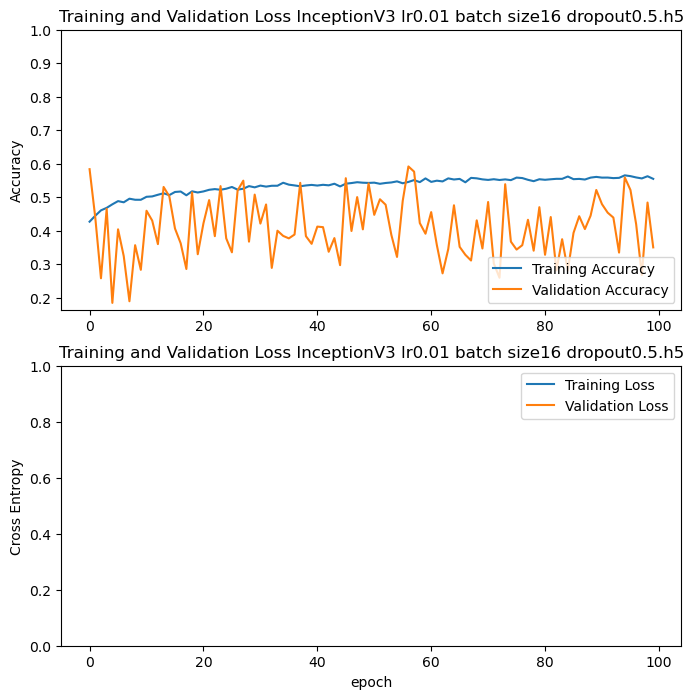

39/39 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.33      0.12      0.17       208
           1       0.26      0.15      0.19       250
           2       0.65      0.85      0.73       767

    accuracy                           0.58      1225
   macro avg       0.41      0.37      0.36      1225
weighted avg       0.51      0.58      0.53      1225



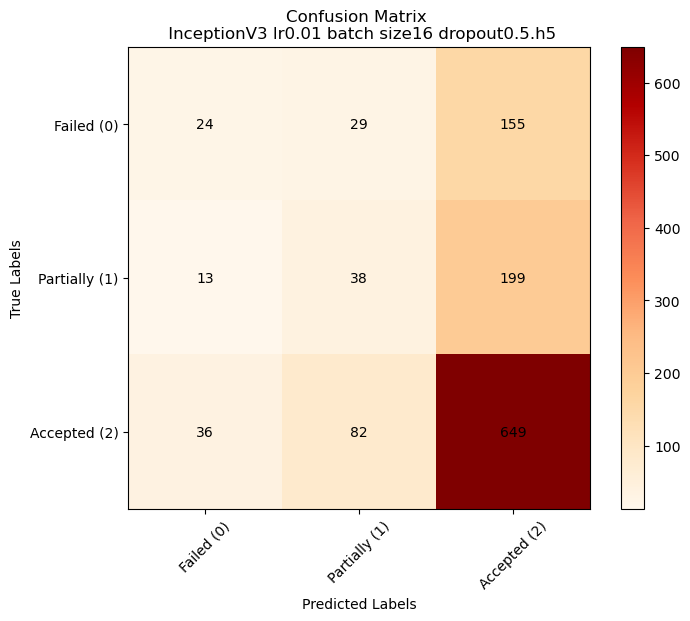

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 3)                 6147      
                                                                 
Total params: 26,005,283
Trainable params: 25,970,851
Non-trainable params: 34,432
_____________________________________

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [16]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.01]
batch_size = [64,32,16]
dropouts = [0.2, 0.5]

####################################################################################################################
#           We define our model specific parameters

model_name = "InceptionV3" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running {len(learning_rate)*len(batch_size)*len(dropouts)} possible models with learning rates:{learning_rate} and batch sizes: {batch_size} with dropouts: {dropouts} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
        for d in dropouts:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} with dropout: {d} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.InceptionV3(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(2048, activation='linear'),  
                tf.keras.layers.Dropout(d),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  


            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  


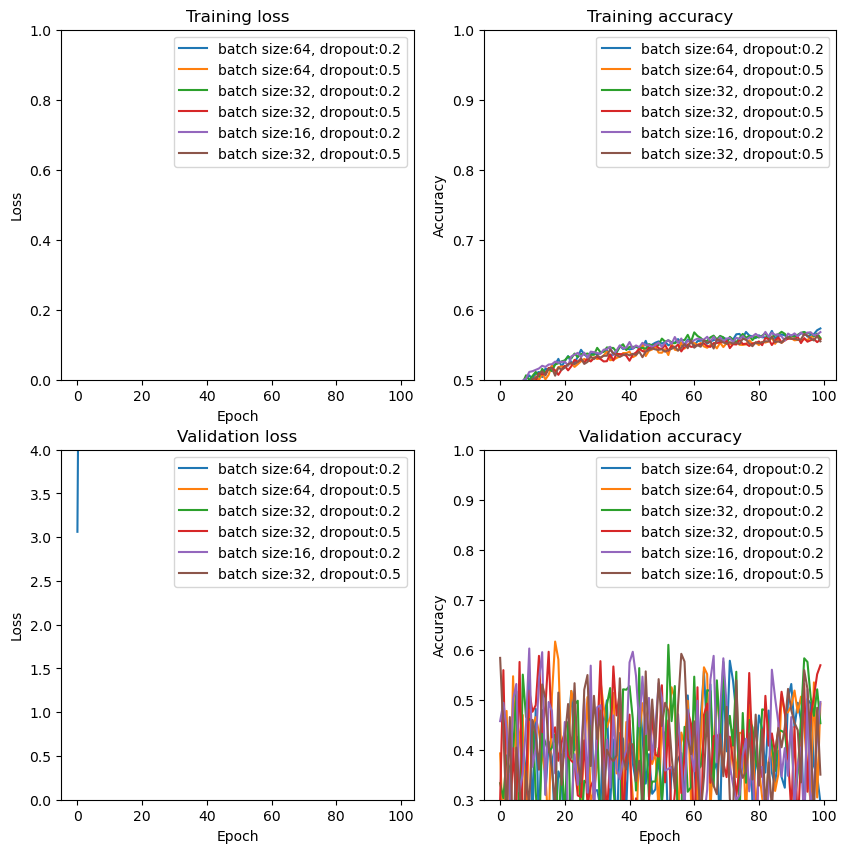

In [19]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['loss'], label='batch size:32, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['accuracy'], label='batch size:32, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_accuracy'], label='batch size:16, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()

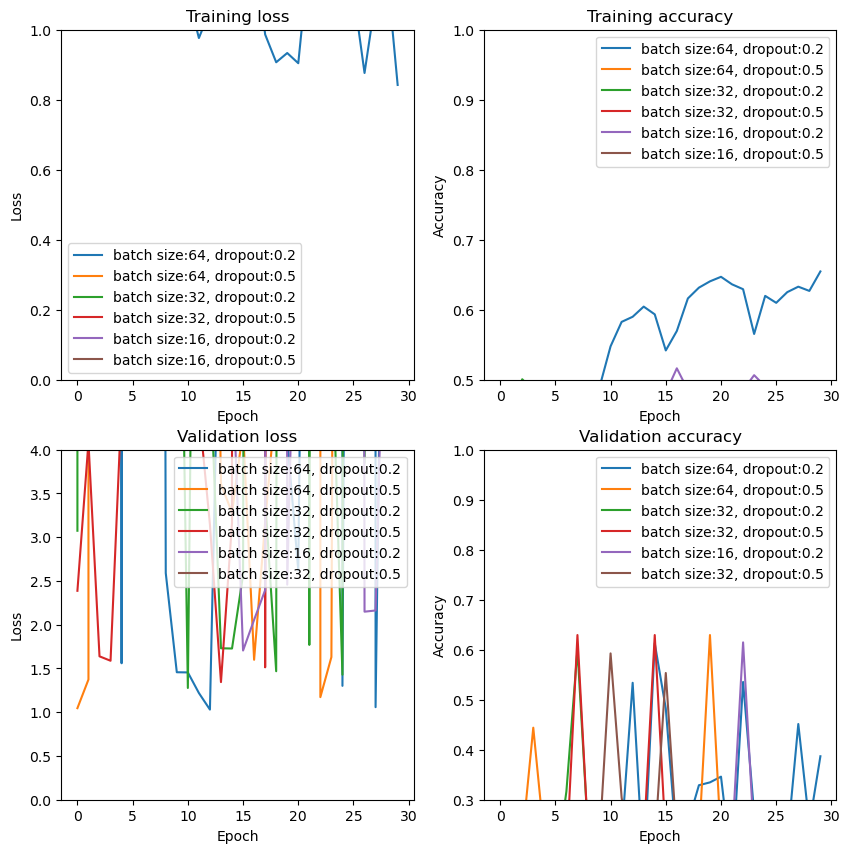

In [20]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(ft_histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['loss'], label='batch size:16, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(ft_histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['accuracy'], label='batch size:16, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(ft_histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(ft_histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_accuracy'], label='batch size:32, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()